### Context.
Unlike in our prior module, Fundamentals of Data Science, this assignment is based on real world data: 
specifically, road traffic accidents in 2019. This assignment is a chance to test your skills against such 
real-world data in order to produce meaningful outputs.
#### Project Background Information.
All road traffic accidents involving casualties are logged and reported in the United Kingdom, along 
with (probably) a majority of other non-fatal road traffic accidents. Every year, the government 
releases a large batch of data associated with these reports. In this assignment we will be using the data 
from 2019 as it represents a very complete sample with a lot of ancillary data available. We have 
uploaded the relevant data to Canvas and it contains the following files:
+ (1) Brief-guide-to road-accidents-and-safety-data. This file contains a very short introduction to the data set produced by the government.
+ (2) variable lookup. This spreadsheet details the large amount of variables present in each of the datasets. 
+ (3) Road Safety Data - Accidents 2019. This spreadsheet contains the details of the accidents logged in 2019.
+ (4) Road Safety Data - Casualties 2019. This spreadsheet details the casualties contained in the logged accidents.
+ (5) Road Safety Data- Vehicles 2019. This spreadsheet contains the details of the vehicles involved in the accidents. 
+ (6) Adjustment Files. These files contain government modelling for the probabilities of different injuries occurring for each accident.
  + (i) adjustment figure guidance. This provides a short amount of government guidance on the figures included. 
  + (ii) cas_adjustment_lookup_2019. This spreadsheet contains the tabulated adjusted probabilities of injuries. 
Please note: some of these files are simply too large to open even within excel. Therefore, it will be 
necessary to undertake analysis within Python. 
#### The Task.
Imagine that you are a data scientist confronted with this data (this is not far from the truth!). Your task 
is to advise government agencies about how to improve road safety and create a model that would 
predict such accidents and the injuries that they incur. 

---
Import necessary libraries

In [1]:
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import statsmodels.api as sm
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings( "ignore" )

In [2]:
pd.set_option('display.max_columns', None) #Display all columns in the dataframe

In [3]:
df_accident = pd.read_csv('Road Safety Data - Accidents 2019.csv')

In [4]:
df_vehicle = pd.read_csv('Road Safety Data- Vehicles 2019.csv')

In [5]:
df_casualty = pd.read_csv('Road Safety Data - Casualties 2019.csv')

# Data Cleaning

### Time

In [6]:
time = df_accident['Time']
df_accident.loc[pd.isna(time),:].index #returns the indexes of the missing entries

Int64Index([   578,    582,   2326,   2417,   2570,   2807,   2987,   4053,
              5362,   5403,   8449,   9199,   9315,   9346,   9961,  10441,
             11271,  13614,  14113,  14581,  14613,  15919,  16102,  17016,
             17163,  17224,  17507,  18729,  19410,  19934,  20259,  20557,
             20649,  22503,  23853,  23994,  24182,  24561,  24911,  30451,
             41090,  41124,  41462,  41519,  41619,  41782,  41964,  41996,
             42151,  42515,  42571,  42647,  42840,  43071,  43163,  43599,
             43694,  43745,  44094,  44177,  44186,  44582, 112149],
           dtype='int64')

In [7]:
#new_ = df_accident.sort_values(by ='Date') #sorts the accident dataframe via the Date column.

In [8]:
def time_update():
    time = df_accident['Time']
    df_accident.loc[pd.isna(time),:].index #returns the indexes of the missing entries
    new_ = df_accident.sort_values(by ='Date') #sorts the accident dataframe via the Date column.
    new_.loc[pd.isna(time),:].index
    df_accident['Time'] = new_['Time'].fillna(method ='bfill') 
    #backfills the missing data in my dataframe using the sorted data's information.
time_update()

In [9]:
df_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               117536 non-null  object 
 1   Location_Easting_OSGR                        117508 non-null  float64
 2   Location_Northing_OSGR                       117508 non-null  float64
 3   Longitude                                    117508 non-null  float64
 4   Latitude                                     117508 non-null  float64
 5   Police_Force                                 117536 non-null  int64  
 6   Accident_Severity                            117536 non-null  int64  
 7   Number_of_Vehicles                           117536 non-null  int64  
 8   Number_of_Casualties                         117536 non-null  int64  
 9   Date                                         117536 non-nul

Creating new columns in my dataframe.

In [10]:
def date_update():
    new_date = df_accident['Date'].str.cat(df_accident['Time'],sep = ' ')
    new_date = pd.to_datetime(new_date)
    df_accident['Date_Time'] = new_date
    df_accident['Week'] = pd.to_datetime(df_accident['Date']).dt.week
    df_accident['Day_name'] = df_accident['Date_Time'].dt.strftime('%a')
    df_accident['Month'] = df_accident['Date_Time'].dt.strftime('%b')
date_update()

In [11]:
df_accident['converted_time']= pd.DatetimeIndex(df_accident['Time'])
df_accident['decimal_time']= df_accident['converted_time'].dt.hour + df_accident['converted_time'].dt.minute/60

<Figure size 864x576 with 0 Axes>

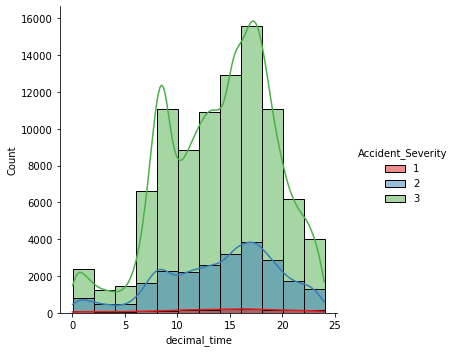

In [12]:
plt.figure(figsize = (12,8))
sns.displot(x= df_accident['decimal_time'], hue = df_accident['Accident_Severity'], bins = 25, kde = True,binwidth = 2,palette = 'Set1')

In [13]:
#split the Date and Time column to obtain the year, month, day and hour
def get_year(x):
    splitted_data = x.split('/')
    return splitted_data[2]
def get_month(x):
    splitted_data = x.split('/')
    return splitted_data[1]
def get_day(x):
    splitted_data = x.split('/')
    return splitted_data[0]
def get_hour(x):
    splitted_time = x.split(':')
    return int(splitted_time[0])

In [14]:
df_accident['Year'] = df_accident['Date'].apply(lambda x : get_year(x))
df_accident['Month'] = df_accident['Date'].apply(lambda x : get_month(x))
df_accident['Day'] = df_accident['Date'].apply(lambda x : get_day(x))
df_accident['Hour'] = df_accident['Time'].apply(lambda x : get_hour(x))

In [15]:
df_accident['Time']= pd.to_datetime(df_accident.Time) #converts time to datatime datatype
df_accident['Date']= pd.to_datetime(df_accident.Date)

In [16]:
df_accident

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,3,2022-09-27 21:45:00,9,E09000022,3,23,2,30,0,-1,-1,0,-1,-1,4,1,1,0,0,1,3,E01003117,2019-01-15 21:45:00,3,Tue,01,2022-09-27 21:45:00,21.750000,2019,15,21
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,3,2022-09-27 01:50:00,2,E09000007,4,504,6,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01000943,2019-01-01 01:50:00,1,Tue,01,2022-09-27 01:50:00,1.833333,2019,01,1
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,2019-01-01,3,2022-09-27 01:20:00,2,E09000007,4,510,6,20,3,4,4,510,0,0,4,1,1,0,0,1,1,E01000973,2019-01-01 01:20:00,1,Tue,01,2022-09-27 01:20:00,1.333333,2019,01,1
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,2019-01-01,3,2022-09-27 00:40:00,28,E09000005,3,4003,6,30,6,4,6,0,0,0,4,1,1,0,0,1,1,E01000546,2019-01-01 00:40:00,1,Tue,01,2022-09-27 00:40:00,0.666667,2019,01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117531,2019984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,1,2019-05-18,7,2022-09-27 01:00:00,917,S12000006,4,725,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-18 01:00:00,20,Sat,05,2022-09-27 01:00:00,1.000000,2019,18,1
117532,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,5,2022-09-27 08:46:00,917,S12000006,3,7,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-30 08:46:00,22,Thu,05,2022-09-27 08:46:00,8.766667,2019,30,8
117533,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,6,2022-09-27 15:30:00,917,S12000006,4,723,6,60,3,4,4,721,0,0,1,1,1,0,0,2,2,NaN,2019-06-21 15:30:00,25,Fri,06,2022-09-27 15:30:00,15.500000,2019,21,15
117534,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,2019-06-29,7,2022-09-27 14:10:00,917,S12000006,6,710,6,30,3,4,6,723,0,0,1,1,1,0,0,2,2,NaN,2019-06-29 14:10:00,26,Sat,06,2022-09-27 14:10:00,14.166667,2019,29,14


In [17]:
df_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 41 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Accident_Index                               117536 non-null  object        
 1   Location_Easting_OSGR                        117508 non-null  float64       
 2   Location_Northing_OSGR                       117508 non-null  float64       
 3   Longitude                                    117508 non-null  float64       
 4   Latitude                                     117508 non-null  float64       
 5   Police_Force                                 117536 non-null  int64         
 6   Accident_Severity                            117536 non-null  int64         
 7   Number_of_Vehicles                           117536 non-null  int64         
 8   Number_of_Casualties                         117536 non-null  in

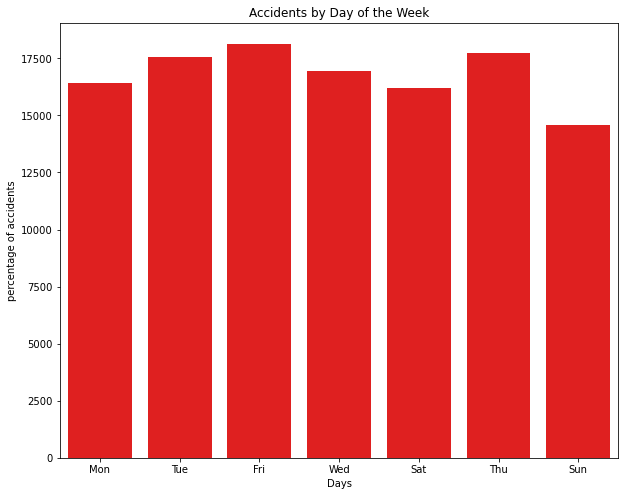

In [18]:
#
days = df_accident['Day_name']
plt.figure(figsize=(10,8))
sns.countplot(days, color='red');
plt.xlabel('Days')
plt.ylabel('percentage of accidents')
plt.title('Accidents by Day of the Week')
plt.show();

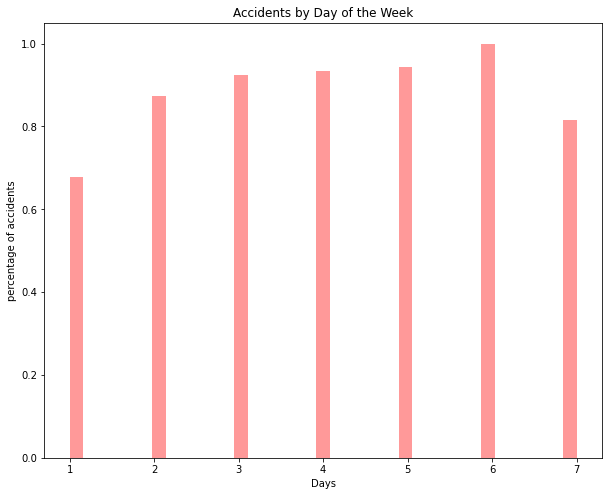

In [19]:
#Accident occurence by day of week
days=df_accident['Day_of_Week']
plt.figure(figsize=(10,8))
sns.distplot(days, kde = False, norm_hist=True, color='red');
plt.xlabel('Days')
plt.ylabel('percentage of accidents')
plt.title('Accidents by Day of the Week')
plt.show();

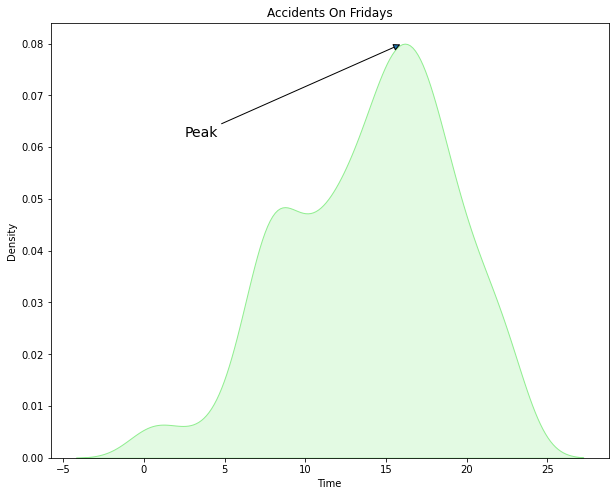

In [20]:
#As we can see friday has the highest percentage of casualities. Lets take a closer look at Friday.
fridays=df_accident[df_accident['Day_of_Week']==6]
fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(fridays.Time.dt.hour,fill=True,bw_adjust=2,color='lightgreen',data=fridays);
plt.annotate('Peak',xy=(16,0.080),xytext=(2.5,0.062),arrowprops={'arrowstyle':'-|>'},fontsize= 14)
plt.title('Accidents On Fridays')
plt.show()

This clearly shows that on fridays most accidents happen at 4pm

In [21]:
#gives a pivot table of the sum of accidents grouped by the accident severity and number of casualties
df = df_accident.pivot_table(index = 'Month', columns = 'Accident_Severity', values = 'Number_of_Casualties', aggfunc = 'sum')

In [22]:
df

Accident_Severity,1,2,3
Month,,,
01,297,2355,9411
02,214,2249,8882
03,199,2481,9454
04,263,2562,9021
05,196,2767,9775
06,201,2785,9970
07,262,2958,10367
08,244,2937,9683
09,235,2970,10048


<AxesSubplot:xlabel='Month'>

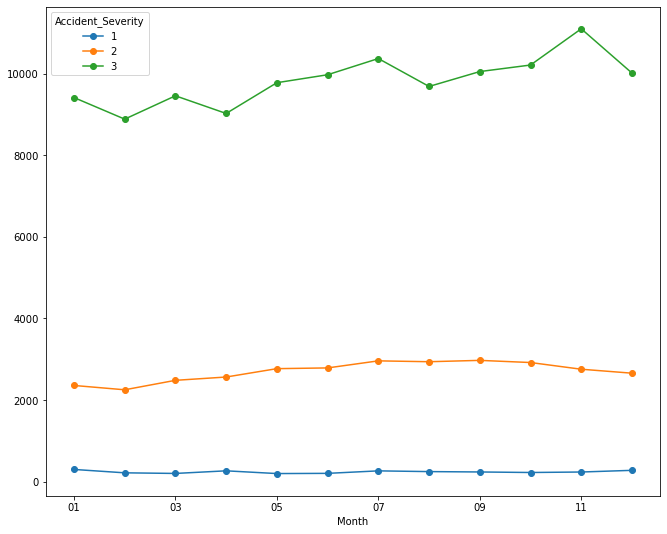

In [23]:
df.plot(figsize = (11,9), kind = 'line', marker = 'o')

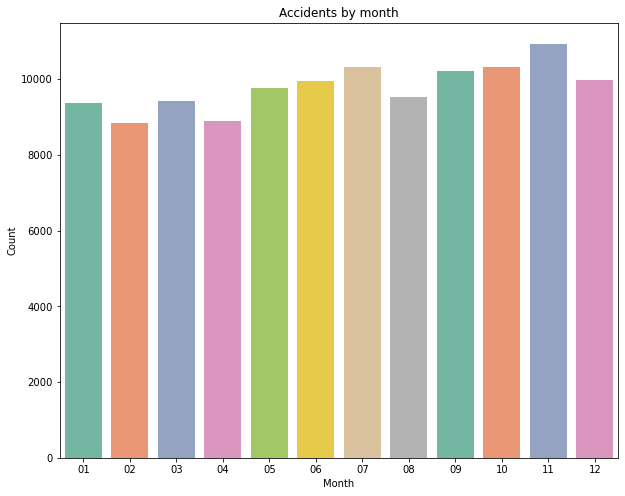

In [24]:
#Monthly Analysis of accidents
fig,axs= plt.subplots(figsize=(10,8))
sns.countplot(x=df_accident['Month'].sort_values(), data=df_accident,palette='Set2')
for i in axs.patches:
    x= i.get_x()+i.get_width()-0.85
    y= i.get_height()+ 10000
    count = '{:,.0f}'.format(i.get_height())
    axs.annotate(count,(x,y))
axs.set(xlabel='Month',ylabel='Count',title='Accidents by month')
plt.show();

In [25]:
#time of accident in november, slight severity.
november_accident = df_accident[(df_accident['Accident_Severity'] == 3) & (df_accident['Month'] == '11')]

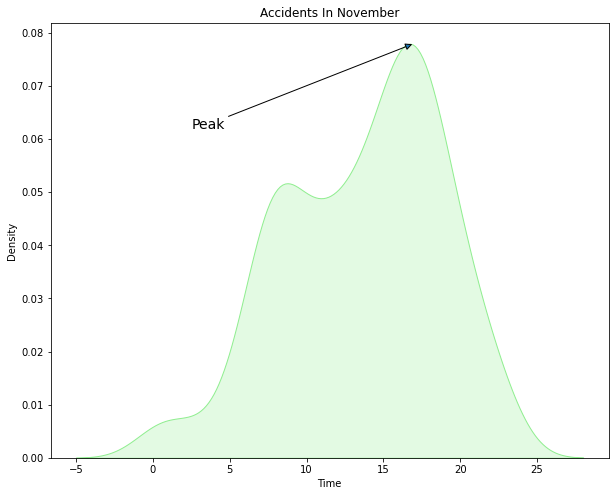

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(november_accident.Time.dt.hour,fill=True,bw_adjust=2,color='lightgreen',data=november_accident);
plt.annotate('Peak',xy=(17,0.078),xytext=(2.5,0.062),arrowprops={'arrowstyle':'-|>'},fontsize= 14)
plt.title('Accidents In November')
plt.show()

in november most accidents occured at 5pm

In [27]:
september_accident_serious = df_accident[(df_accident['Accident_Severity'] == 2) & (df_accident['Month'] == '09')]

<AxesSubplot:xlabel='Day_of_Week', ylabel='Count'>

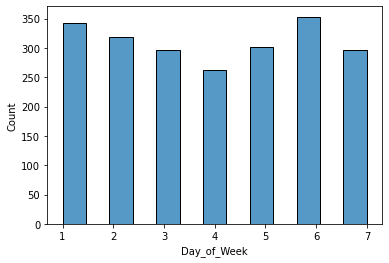

In [28]:
sns.histplot(september_accident_serious, x = 'Day_of_Week')

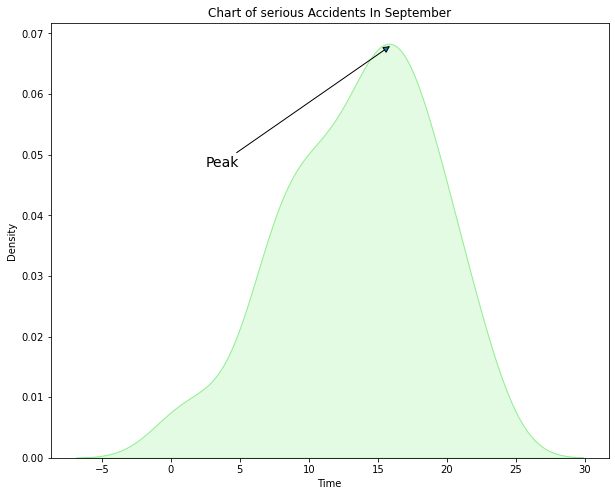

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(september_accident_serious.Time.dt.hour,fill=True,bw_adjust=2,color='lightgreen',data=september_accident_serious);
plt.annotate('Peak',xy=(16,0.0681),xytext=(2.5,0.048),arrowprops={'arrowstyle':'-|>'},fontsize= 14)
plt.title('Chart of serious Accidents In September')
plt.show()

In [30]:
january_accident_fatal = df_accident[(df_accident['Accident_Severity'] == 1) & (df_accident['Month'] == '01')]

In [31]:
january_accident_fatal

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour
11,2019010155210,537356.0,183448.0,-0.021065,51.533238,1,1,1,1,2019-01-01,3,2022-09-27 03:00:00,5,E09000030,3,12,3,40,0,-1,-1,0,0,0,6,1,1,0,0,1,1,E01032764,2019-01-01 03:00:00,1,Tue,01,2022-09-27 03:00:00,3.000000,2019,01,3
226,2019010156081,528803.0,174103.0,-0.147713,51.451270,1,1,1,1,2019-07-01,2,2022-09-27 09:04:00,10,E09000032,3,24,6,30,9,2,6,0,0,5,1,1,1,0,0,1,1,E01004476,2019-07-01 09:04:00,27,Mon,01,2022-09-27 09:04:00,9.066667,2019,07,9
510,2019010157046,530459.0,173827.0,-0.123996,51.448411,1,1,1,1,2019-12-01,7,2022-09-27 00:20:00,9,E09000022,3,23,6,20,0,-1,-1,0,0,4,4,1,1,0,0,1,1,E01003024,2019-12-01 00:20:00,48,Sun,01,2022-09-27 00:20:00,0.333333,2019,12,0
599,2019010157331,534774.0,169298.0,-0.063660,51.406701,1,1,1,2,2019-01-13,1,2022-09-27 20:08:00,19,E09000006,3,213,6,30,3,4,6,0,0,4,4,8,1,0,6,1,1,E01000743,2019-01-13 20:08:00,2,Sun,01,2022-09-27 20:08:00,20.133333,2019,13,20
1146,2019010158971,537776.0,189785.0,-0.012533,51.590080,1,1,1,1,2019-01-22,3,2022-09-27 23:42:00,13,E09000031,3,503,6,20,0,-1,-1,0,0,1,4,1,2,0,0,1,1,E01004342,2019-01-22 23:42:00,4,Tue,01,2022-09-27 23:42:00,23.700000,2019,22,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116664,201997KB70201,243449.0,664276.0,-4.501980,55.846205,97,1,1,1,2019-01-15,3,2022-09-27 16:45:00,935,S12000038,6,0,6,30,0,-1,-1,0,0,0,4,1,2,0,0,1,1,NaN,2019-01-15 16:45:00,3,Tue,01,2022-09-27 16:45:00,16.750000,2019,15,16
117033,201997QA75301,264529.0,653979.0,-4.160457,55.760137,97,1,1,1,2019-01-17,5,2022-09-27 10:10:00,938,S12000029,6,0,6,30,0,-1,-1,0,0,0,1,1,1,0,0,1,1,NaN,2019-01-17 10:10:00,3,Thu,01,2022-09-27 10:10:00,10.166667,2019,17,10
117083,201997QB75501,273394.0,655867.0,-4.020165,55.779492,97,1,1,1,2019-01-29,3,2022-09-27 15:35:00,938,S12000029,1,74,7,70,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-01-29 15:35:00,5,Tue,01,2022-09-27 15:35:00,15.583333,2019,29,15
117127,201997QC75101,295857.0,638306.0,-3.655520,55.627137,97,1,3,4,2019-09-01,4,2022-09-27 16:50:00,938,S12000029,3,73,6,60,8,4,6,0,0,0,6,1,1,0,0,2,1,NaN,2019-09-01 16:50:00,35,Sun,01,2022-09-27 16:50:00,16.833333,2019,09,16


<AxesSubplot:xlabel='Day_of_Week', ylabel='Count'>

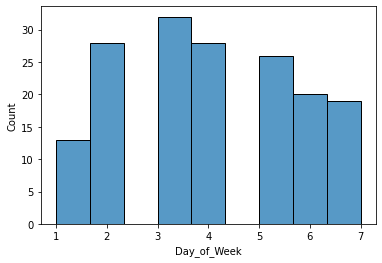

In [32]:
sns.histplot(january_accident_fatal, x = 'Day_of_Week')

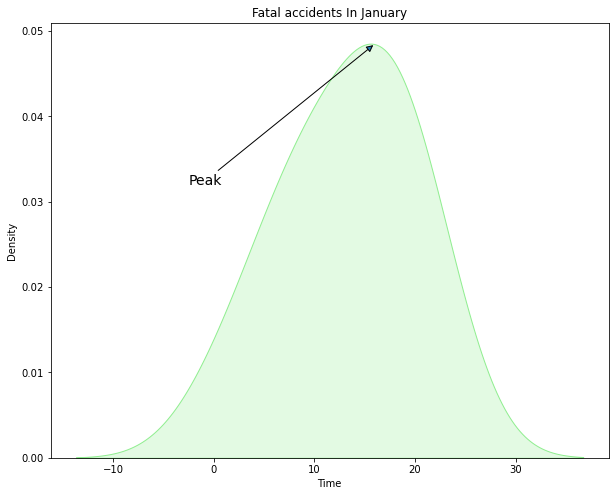

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(january_accident_fatal.Time.dt.hour,fill=True,bw_adjust=2,color='lightgreen',data=january_accident_fatal);
plt.annotate('Peak',xy=(16,0.0485),xytext=(-2.5,0.032),arrowprops={'arrowstyle':'-|>'},fontsize= 14)
plt.title('Fatal accidents In January')
plt.show()

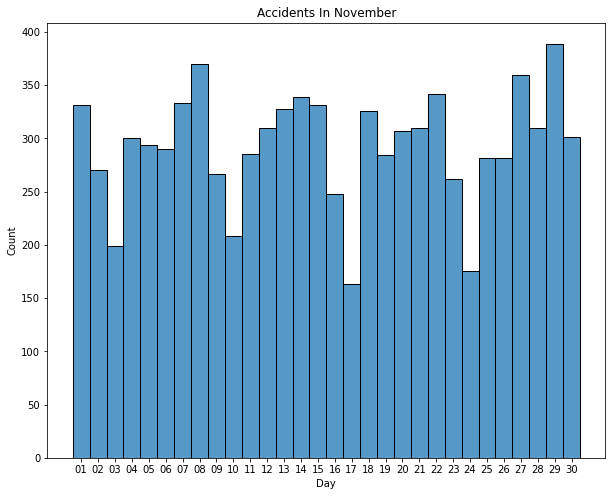

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(november_accident['Day'], kde = False, bins = 30)
plt.title('Accidents In November')
plt.show()

blackfriday in the Uk in 2019, was on the 29th of November
                               27th november accidents caused by thanksgiving shopping
                               

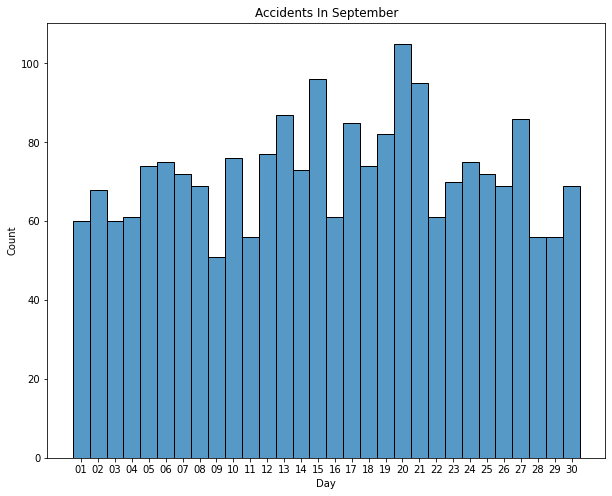

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(september_accident_serious['Day'], kde = False, bins = 30)
plt.title('Accidents In September')
plt.show()

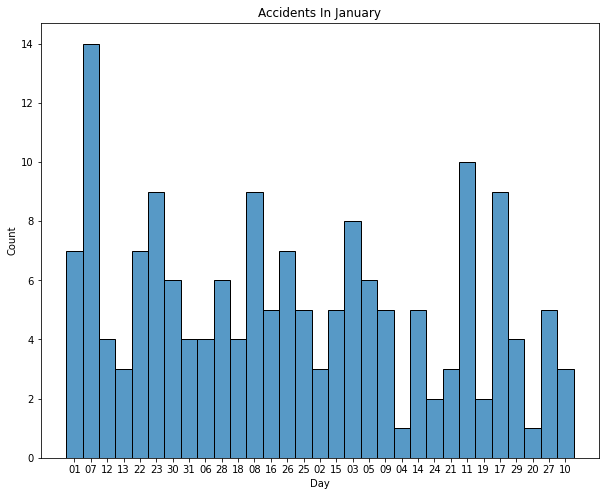

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(january_accident_fatal['Day'], kde = False, bins = 30)
plt.title('Accidents In January')
plt.show()

In [37]:
january_accident_fatal = df_accident[(df_accident['Accident_Severity'] == 1) & (df_accident['Month'] == '01') & (df_accident['Day'] == '07')]

In [38]:
len(january_accident_fatal)

14

In [39]:
df_accident

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,3,2022-09-27 21:45:00,9,E09000022,3,23,2,30,0,-1,-1,0,-1,-1,4,1,1,0,0,1,3,E01003117,2019-01-15 21:45:00,3,Tue,01,2022-09-27 21:45:00,21.750000,2019,15,21
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,3,2022-09-27 01:50:00,2,E09000007,4,504,6,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01000943,2019-01-01 01:50:00,1,Tue,01,2022-09-27 01:50:00,1.833333,2019,01,1
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,2019-01-01,3,2022-09-27 01:20:00,2,E09000007,4,510,6,20,3,4,4,510,0,0,4,1,1,0,0,1,1,E01000973,2019-01-01 01:20:00,1,Tue,01,2022-09-27 01:20:00,1.333333,2019,01,1
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,2019-01-01,3,2022-09-27 00:40:00,28,E09000005,3,4003,6,30,6,4,6,0,0,0,4,1,1,0,0,1,1,E01000546,2019-01-01 00:40:00,1,Tue,01,2022-09-27 00:40:00,0.666667,2019,01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117531,2019984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,1,2019-05-18,7,2022-09-27 01:00:00,917,S12000006,4,725,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-18 01:00:00,20,Sat,05,2022-09-27 01:00:00,1.000000,2019,18,1
117532,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,5,2022-09-27 08:46:00,917,S12000006,3,7,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-30 08:46:00,22,Thu,05,2022-09-27 08:46:00,8.766667,2019,30,8
117533,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,6,2022-09-27 15:30:00,917,S12000006,4,723,6,60,3,4,4,721,0,0,1,1,1,0,0,2,2,NaN,2019-06-21 15:30:00,25,Fri,06,2022-09-27 15:30:00,15.500000,2019,21,15
117534,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,2019-06-29,7,2022-09-27 14:10:00,917,S12000006,6,710,6,30,3,4,6,723,0,0,1,1,1,0,0,2,2,NaN,2019-06-29 14:10:00,26,Sat,06,2022-09-27 14:10:00,14.166667,2019,29,14


# D Daylight Savings

In [40]:
df_accident.week = pd.to_numeric(df_accident.Week)

<AxesSubplot:xlabel='Week'>

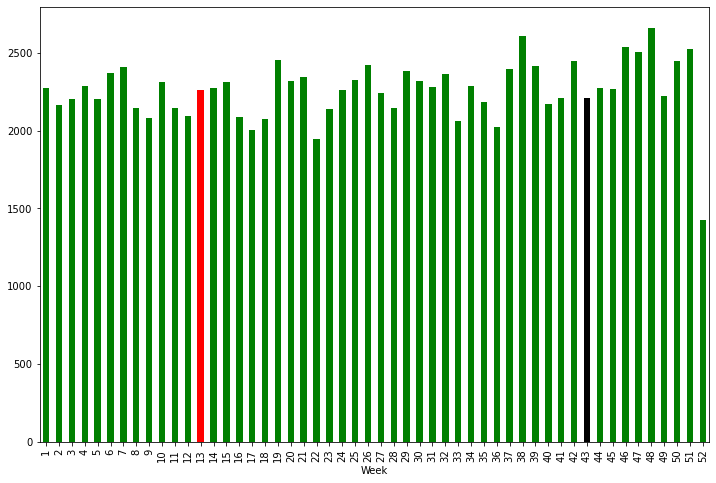

In [41]:
c = ['red' if x == 12 else 'black' if x == 42 else 'green' for x in df_accident.Week.keys()] #Because it starts counting from 0
df_accident.groupby('Week', group_keys = True)['Number_of_Casualties'].count().plot(kind = 'bar', color = c, figsize = (12,8))


In [42]:
daylight_savings = df_accident[(df_accident['Date'].between('2019-03-31','2019-10-27'))].describe()['Number_of_Casualties']
daylight_savings

count    67948.000000
mean         1.311253
std          0.779069
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         52.000000
Name: Number_of_Casualties, dtype: float64

In [43]:
Not_daylight_savings = df_accident[(df_accident['Date'].between('2019-01-01','2019-03-30')) + (df_accident['Date'].between('2019-10-27','2019-12-31'))].describe()['Number_of_Casualties']
Not_daylight_savings

count    49869.000000
mean         1.291805
std          0.718942
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: Number_of_Casualties, dtype: float64

In [44]:
week_daylight_start = df_accident[(df_accident['Date'].between('2019-03-24','2019-04-07'))].describe()['Number_of_Casualties']
week_daylight_start

count    4831.000000
mean        1.284413
std         0.767510
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        25.000000
Name: Number_of_Casualties, dtype: float64

In [45]:
week_daylight_ends = df_accident[(df_accident['Date'].between('2019-10-20','2019-11-03'))].describe()['Number_of_Casualties']
week_daylight_ends

count    4714.000000
mean        1.300382
std         0.751639
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: Number_of_Casualties, dtype: float64

In [46]:
import numpy as np

In [47]:
np.var(week_daylight_start)

2548031.0782207106

In [48]:
print(np.var(week_daylight_start), np.var(week_daylight_ends))

2548031.0782207106 2427285.5829250147


In [49]:
ratio_check = np.var(week_daylight_start)/np.var(week_daylight_ends)

print(ratio_check)
#Obviously, the ratio is less than 4:1, thus the variances are considered to be equal.

1.0497450716739276


In [50]:
print(stats.ttest_ind(a=week_daylight_start, b=week_daylight_ends, equal_var=True))


Ttest_indResult(statistic=0.018681806926503928, pvalue=0.9853585809268572)


Evaluating this:

H0: The mean of both samples (week_daylight_start and week_daylight_ends) are equal.

H1: The mean of both samples (week_daylight_start and week_daylight_ends) are not equal.

Our p-value (p=0.9853585809268572) is greater than alpha = 0.05.

However, interpreting any form of t-test largely depends on the p-value, the result above explains that the means of the two samples (week_daylight_start and week_daylight_ends) are equal.

Therefore we will dismiss the alternate hypothesis which says the mean of the two samples are not same so also their variances are assumed to be equal.

There is no evidence sustainable enough to prove the two timeframes have different means. H0 (null hypothesis) is however true.

We can conclude that during the period of Daylight savings the total number of accidents are more than the period of standard
but most of these accidents occured during daylight. So we cant conclude Daytime Savings necessarily has an effect on the accidents.

# E Sunrise and Sunset

In [51]:
Sunrise_daylight = df_accident[(df_accident['Date'].between('2019-03-31','2019-10-27')) & (df_accident['Time'].between('06:00','07:00'))]

In [52]:
Sunset_daylight = df_accident[(df_accident['Date'].between('2019-03-31','2019-10-27')) & (df_accident['Time'].between('19:00','20:00'))]

In [53]:
Sunrise_non_daylight = Not_daylight_savings = df_accident[((df_accident['Date'].between('2019-01-01','2019-03-30')) + 
                                                          (df_accident['Date'].between('2019-10-28','2019-12-31'))) &
                                                         (df_accident['Time'].between('07:00','08:00'))]


In [54]:
Sunset_non_daylight = Not_daylight_savings = df_accident[((df_accident['Date'].between('2019-01-01','2019-03-30')) + 
                                                          (df_accident['Date'].between('2019-10-28','2019-12-31'))) &
                                                         (df_accident['Time'].between('16:00','17:00'))]

In [55]:
#This puts into consideration the time difference between sunrise and sunset during daylight savings and non daylight savings  
Sunrise = df_accident[((df_accident['Date'].between('2019-03-31','2019-10-27')) &
                       (df_accident['Time'].between('06:00','07:00'))) + 
                      (((df_accident['Date'].between('2019-01-01','2019-03-30'))
                        + (df_accident['Date'].between('2019-10-28','2019-12-31'))) & 
                       (df_accident['Time'].between('07:00','08:00')))].describe()['Number_of_Casualties']
Sunrise

count    4224.000000
mean        1.223011
std         0.602686
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: Number_of_Casualties, dtype: float64

In [56]:
Sunset = df_accident[((df_accident['Date'].between('2019-03-31','2019-10-27')) & 
                      (df_accident['Time'].between('19:00','20:00'))) + 
                     (((df_accident['Date'].between('2019-01-01','2019-03-30')) + 
                            (df_accident['Date'].between('2019-10-28','2019-12-31'))) &
                            (df_accident['Time'].between('16:00','17:00')))].describe()['Number_of_Casualties']

In [57]:
print(np.var(Sunrise), np.var(Sunset))

1949538.4308934414 7732758.534561666


In [58]:
ratio_check = np.var(Sunset)/np.var(Sunrise)

print(ratio_check)


3.9664560657149344


In [59]:
t_value, p_value = stats.ttest_ind(a=Sunrise, b=Sunset)
one_tailed_p_value = (p_value/2)
print(f't_value: {t_value}, p_value: {p_value},one_tailed_p_value: {one_tailed_p_value}')


t_value: -0.44631215066274654, p_value: 0.6621972405389431,one_tailed_p_value: 0.33109862026947157


In [60]:
'''Evaluating this:

H0: The mean of both samples (week_daylight_start and week_daylight_ends) are equal.

H1: The mean of both samples (week_daylight_start and week_daylight_ends) are not equal.

Our p-value (p=0.9853585809268572) is greater than alpha = 0.05.

However, interpreting any form of t-test largely depends on the p-value, the result above explains 

that the means of the two samples (week_daylight_start and week_daylight_ends) are equal.

Therefore we will dismiss the alternate hypothesis which says the mean of the two samples are not same so also their variances are assumed to be equal.

There is no evidence sustainable enough to prove the two timeframes have different means. H0 (null hypothesis) is however true.'''

'Evaluating this:\n\nH0: The mean of both samples (week_daylight_start and week_daylight_ends) are equal.\n\nH1: The mean of both samples (week_daylight_start and week_daylight_ends) are not equal.\n\nOur p-value (p=0.9853585809268572) is greater than alpha = 0.05.\n\nHowever, interpreting any form of t-test largely depends on the p-value, the result above explains \n\nthat the means of the two samples (week_daylight_start and week_daylight_ends) are equal.\n\nTherefore we will dismiss the alternate hypothesis which says the mean of the two samples are not same so also their variances are assumed to be equal.\n\nThere is no evidence sustainable enough to prove the two timeframes have different means. H0 (null hypothesis) is however true.'

<AxesSubplot:xlabel='Hour'>

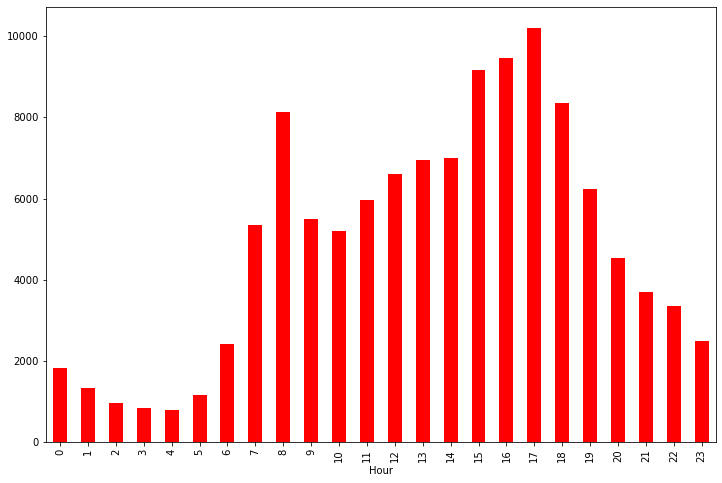

In [61]:
df_accident.groupby('Hour')['Number_of_Casualties'].count().plot(kind = 'bar', color = 'red', figsize = (12,8))

Sunrise and Sunset effects. most accidents occured during the day from the hours of 7am - 7pm.

### Latitude and Longitude

In [62]:
Police_values = []
mode = df_accident.groupby('Police_Force')
unique_police_values = df_accident['Police_Force'].unique()
values = unique_police_values.tolist()
for x in values:
    new_value = mode.get_group(x)
    Police_values.append([new_value['Latitude'].median(),new_value['Longitude'].median(),
                          new_value['Location_Easting_OSGR'].median(),new_value['Location_Northing_OSGR'].median()])
Updated_police_values = dict(zip(values,Police_values))

In [63]:
#Updated_police_values

In [64]:
empty_rows = df_accident[df_accident['Latitude'].isna()] #capture the index of missing columns 

In [65]:
def update_values(df,row,empty):
    for i in row.items():
        for k,j in empty.iterrows():
            if j['Police_Force'] == i[0]:
                df.loc[[k],'Latitude'],df.loc[[k],'Longitude'],df.loc[[k],'Location_Easting_OSGR'],df.loc[[k],'Location_Northing_OSGR'] = i[1][0],i[1][1],i[1][2],i[1][3] ##update longitude and latitude as a tuple

In [66]:
update_values(df_accident,Updated_police_values,empty_rows)

### Q F

In [67]:
df_vehicle['Age_of_Vehicle'] = pd.to_numeric(df_vehicle['Age_of_Vehicle'])

In [68]:
def map_vehicle_age(x):
    if x > 0 and  x < 6:
        return 1
    elif x > 5 and  x < 11:
        return 2
    elif x > 10 and  x < 16:
        return 3
    elif x > 15 and  x < 21:
        return 4
    elif x > 20 and  x < 26:
        return 5
    elif x > 25 and  x < 36:
        return 6
    elif x > 35 and  x < 46:
        return 7
    elif x > 45 and  x < 56:
        return 8
    elif x > 55 and  x < 66:
        return 9
    elif x > 65 and  x < 76:
        return 10
    elif x > 75:
        return 11

In [69]:
df_vehicle['Vehicle_Age_Band'] = df_vehicle['Age_of_Vehicle'].apply(lambda x : map_vehicle_age(x))

In [70]:
def map_engine_capacity_index(x):
    if ((x >= 0) and  (x <= 2000)) :
        return 1
    elif ((x >= 2001) and  (x <= 4000)):
        return 2
    elif ((x >= 4001) and  (x <= 6000)):
        return 3
    elif ((x >= 6001) and  (x <= 8000)):
        return 4
    elif ((x >= 8001) and  (x <= 10000)):
        return 5
    elif ((x >= 10001) and  (x <= 12000)):
        return 6
    elif ((x >= 12001) and  (x <= 14000)):
        return 7
    elif ((x >= 14001) and  (x <= 16000)):
        return 8
    elif ((x >= 16001) and  (x <= 18000)):
        return 9
    elif ((x >= 18001) and  (x <= 20000)):
        return 10
    elif ((x >= 20001) and  (x <= 22000)):
        return 11
    elif ((x >= 22001) and  (x <= 24000)):
        return 12
    elif ((x >= 24001) and  (x <= 26000)):
        return 13
    elif ((x >= 26001) and  (x <= 28000)):
        return 14
    elif ((x >= 28001) and  (x <= 30000)):
        return 15
    elif x > 30000:
        return 16

In [71]:
df_vehicle['Engine_capacity_band'] = df_vehicle['Engine_Capacity_(CC)'].apply(lambda x : map_engine_capacity_index(x))

In [72]:
#df_vehicle_condition['Engine_capacity_band'] = df_vehicle_condition['Engine_capacity_band'].astype(int)

In [73]:
df_vehicle_accident = pd.merge(df_accident, df_vehicle, on = 'Accident_Index', how = 'inner')

In [74]:
#df_vehicle_condition['Vehicle_Age_Band'] = df_vehicle_condition['Vehicle_Age_Band'].astype(int)

In [75]:
value = df_vehicle_accident[['Engine_capacity_band','Vehicle_Age_Band','Was_Vehicle_Left_Hand_Drive?', 'Propulsion_Code', 'Accident_Severity']]

In [76]:
df_vehicle_conditions = value[(value['Engine_capacity_band']>-1) & (value['Vehicle_Age_Band']>-1) & (value['Was_Vehicle_Left_Hand_Drive?']>-1) & (value['Propulsion_Code']>-1)]

In [77]:
df_vehicle_conditions

,Engine_capacity_band,Vehicle_Age_Band,Was_Vehicle_Left_Hand_Drive?,Propulsion_Code,Accident_Severity
15,1.0,1.0,1,1,3
16,1.0,1.0,1,1,3
21,2.0,1.0,1,2,1
23,1.0,1.0,1,1,2
24,1.0,1.0,1,1,2
...,...,...,...,...,...
175660,2.0,1.0,1,2,3
175661,1.0,3.0,1,2,3
175662,2.0,1.0,1,2,3
175663,1.0,2.0,1,2,3


In [78]:
#! pip install mlxtend

In [79]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [80]:
df_condition_1 = pd.get_dummies(df_vehicle_conditions['Engine_capacity_band'], prefix = 'engine')
df_condition_2 = pd.get_dummies(df_vehicle_conditions['Vehicle_Age_Band'], prefix = 'age_band')
df_condition_3 = pd.get_dummies(df_vehicle_conditions['Was_Vehicle_Left_Hand_Drive?'], prefix = 'hand_drive')
df_condition_4 = pd.get_dummies(df_vehicle_conditions['Propulsion_Code'], prefix = 'propulsion')
df_condition_5 = pd.get_dummies(df_vehicle_conditions['Accident_Severity'],  prefix = 'severity')
df_vehicle_condition = pd.concat([df_condition_1,df_condition_2,df_condition_3,df_condition_4,df_condition_5], axis = 1)

In [81]:
df_condition_1 = pd.get_dummies(df_vehicle_conditions['Engine_capacity_band'], prefix = 'engine')

In [82]:
df_condition_2 = pd.get_dummies(df_vehicle_conditions['Vehicle_Age_Band'], prefix = 'age_band')

In [83]:
df_condition_3 = pd.get_dummies(df_vehicle_conditions['Was_Vehicle_Left_Hand_Drive?'], prefix = 'hand_drive')

In [84]:
df_condition_4 = pd.get_dummies(df_vehicle_conditions['Propulsion_Code'], prefix = 'propulsion')

In [85]:
df_condition_5 = pd.get_dummies(df_vehicle_conditions['Accident_Severity'],  prefix = 'severity')

In [86]:
df_vehicle_condition = pd.concat([df_condition_1,df_condition_2,df_condition_3,df_condition_4,df_condition_5], axis = 1)

In [87]:
from mlxtend.frequent_patterns import association_rules
frequent = apriori(df_vehicle_condition, min_support = 0.2, use_colnames = True)

In [88]:
df_vehicle_condition

,engine_1.0,engine_2.0,engine_3.0,engine_4.0,engine_5.0,engine_6.0,engine_7.0,engine_8.0,engine_9.0,engine_15.0,age_band_1.0,age_band_2.0,age_band_3.0,age_band_4.0,age_band_5.0,age_band_6.0,age_band_7.0,age_band_8.0,age_band_9.0,age_band_10.0,age_band_11.0,hand_drive_1,hand_drive_2,propulsion_1,propulsion_2,propulsion_5,propulsion_6,propulsion_7,propulsion_8,propulsion_12,severity_1,severity_2,severity_3
15,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
16,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
21,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
24,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175660,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
175661,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
175662,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
175663,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [89]:
frequent = apriori(df_vehicle_condition, min_support = 0.5, use_colnames = True)

In [90]:
frequent

,support,itemsets
0,0.835712,(engine_1.0)
1,0.994976,(hand_drive_1)
2,0.531170,(propulsion_1)
3,0.790319,(severity_3)
4,0.831635,"(engine_1.0, hand_drive_1)"
5,0.511075,"(engine_1.0, propulsion_1)"
6,0.662868,"(engine_1.0, severity_3)"
7,0.528671,"(propulsion_1, hand_drive_1)"
8,0.786550,"(hand_drive_1, severity_3)"
9,0.508713,"(engine_1.0, propulsion_1, hand_drive_1)"


In [91]:
rules = association_rules(frequent, metric = 'lift', min_threshold = 0.5)

In [92]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(engine_1.0),(hand_drive_1),0.835712,0.994976,0.831635,0.995122,1.000146,0.000121,1.029778
1,(hand_drive_1),(engine_1.0),0.994976,0.835712,0.831635,0.835834,1.000146,0.000121,1.000743
2,(engine_1.0),(propulsion_1),0.835712,0.531170,0.511075,0.611545,1.151317,0.067170,1.206910
3,(propulsion_1),(engine_1.0),0.531170,0.835712,0.511075,0.962169,1.151317,0.067170,4.342696
4,(engine_1.0),(severity_3),0.835712,0.790319,0.662868,0.793178,1.003618,0.002389,1.013823
5,(severity_3),(engine_1.0),0.790319,0.835712,0.662868,0.838735,1.003618,0.002389,1.018747
6,(propulsion_1),(hand_drive_1),0.531170,0.994976,0.528671,0.995295,1.000320,0.000169,1.067778
7,(hand_drive_1),(propulsion_1),0.994976,0.531170,0.528671,0.531340,1.000320,0.000169,1.000363
8,(hand_drive_1),(severity_3),0.994976,0.790319,0.786550,0.790521,1.000255,0.000200,1.000962
9,(severity_3),(hand_drive_1),0.790319,0.994976,0.786550,0.995230,1.000255,0.000200,1.053163


## 1G

In [93]:
weather = pd.get_dummies(df_accident['Weather_Conditions'], 'weather')
light = pd.get_dummies(df_accident['Light_Conditions'], 'light')
road = pd.get_dummies(df_accident['Road_Surface_Conditions'], 'Road')
severity = pd.get_dummies(df_accident['Accident_Severity'], 'Severity')
speed = pd.get_dummies(df_accident['Speed_limit'], 'speed') 


In [94]:
condition = pd.concat([severity,light,road, weather], axis = 1)


In [95]:
frequent = apriori(condition, min_support = 0.3, use_colnames = True)


In [96]:
rule = association_rules(frequent, metric = 'lift', min_threshold = 0.5)


In [97]:
rule[(rule['confidence']> 0.9) & (rule['lift']>1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(Road_1),(weather_1),0.700390,0.785427,0.661848,0.944972,1.203130,0.111743,3.899300
26,"(Severity_3, Road_1)",(weather_1),0.552069,0.785427,0.520011,0.941931,1.199259,0.086401,3.695113
31,"(light_1, Road_1)",(weather_1),0.545220,0.785427,0.517339,0.948863,1.208085,0.089108,4.196049
38,"(light_1, Severity_3, Road_1)",(weather_1),0.432931,0.785427,0.409253,0.945308,1.203559,0.069217,3.923293


## 1H

In [98]:
sex = pd.get_dummies(df_vehicle_accident['Sex_of_Driver'], 'Sex')
purpose = pd.get_dummies(df_vehicle_accident['Journey_Purpose_of_Driver'], 'Journey_purpose')
Age_band = pd.get_dummies(df_vehicle_accident['Age_Band_of_Driver'], 'Age')
severity = pd.get_dummies(df_vehicle_accident['Accident_Severity'], 'Severity')


In [99]:
Driver_variable = pd.concat([sex,Age_band, purpose, severity], axis = 1)                                                                             

In [100]:
frequent = apriori(Driver_variable , min_support = 0.2, use_colnames = True)

In [101]:
rule = association_rules(frequent, metric = 'lift', min_threshold = 1)

In [102]:
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Severity_3),(Sex_2),0.798930,0.264765,0.219065,0.274198,1.035625,0.007536,1.012996
1,(Sex_2),(Severity_3),0.264765,0.798930,0.219065,0.827392,1.035625,0.007536,1.164895
2,(Journey_purpose_6),(Severity_3),0.615404,0.798930,0.501802,0.815402,1.020617,0.010137,1.089231
3,(Severity_3),(Journey_purpose_6),0.798930,0.615404,0.501802,0.628092,1.020617,0.010137,1.034116


### checking effects of Light, weather, and road Surface on Accidents

In [103]:
# selecting some feature columns
df_conditions = df_accident[['Light_Conditions','Weather_Conditions','Road_Surface_Conditions']]

In [104]:
# setting accident severity as our target data
df_conditions['Severity'] = df_accident['Accident_Severity']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


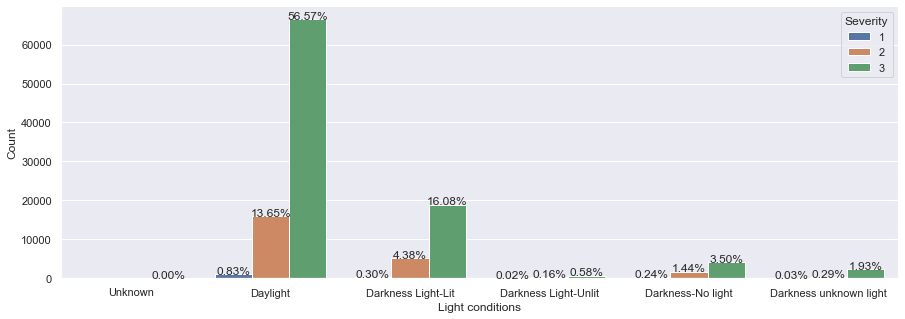

In [105]:
#visualizing the conditions based on the accident severity percentage
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
lightplot = sns.countplot(x='Light_Conditions',data=df_conditions,hue='Severity')
lightplot.set(xlabel='Light conditions', ylabel='Count',xticklabels=['Unknown','Daylight','Darkness Light-Lit','Darkness Light-Unlit','Darkness-No light','Darkness unknown light'])
for p in lightplot.patches: 
    height = p.get_height() 
    lightplot.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(df_accident['decimal_time']))*100)+'%',  
      ha="center")     
plt.show()


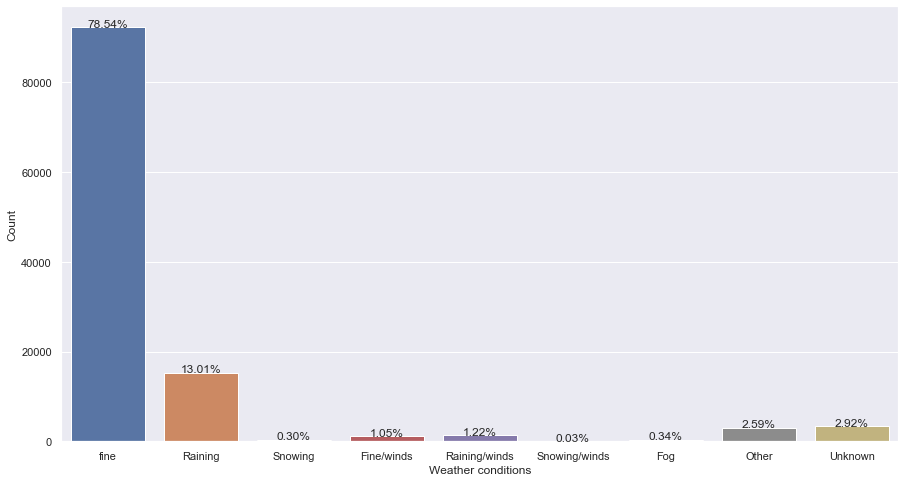

In [106]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
weatherplot = sns.countplot(x='Weather_Conditions',data=df_conditions)
weatherplot.set(xlabel='Weather conditions', ylabel='Count',xticklabels=['fine','Raining','Snowing','Fine/winds','Raining/winds','Snowing/winds','Fog','Other','Unknown'])
for p in weatherplot.patches: 
    height = p.get_height() 
    weatherplot.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(df_accident['decimal_time']))*100)+'%',  
      ha="center") 
plt.show()


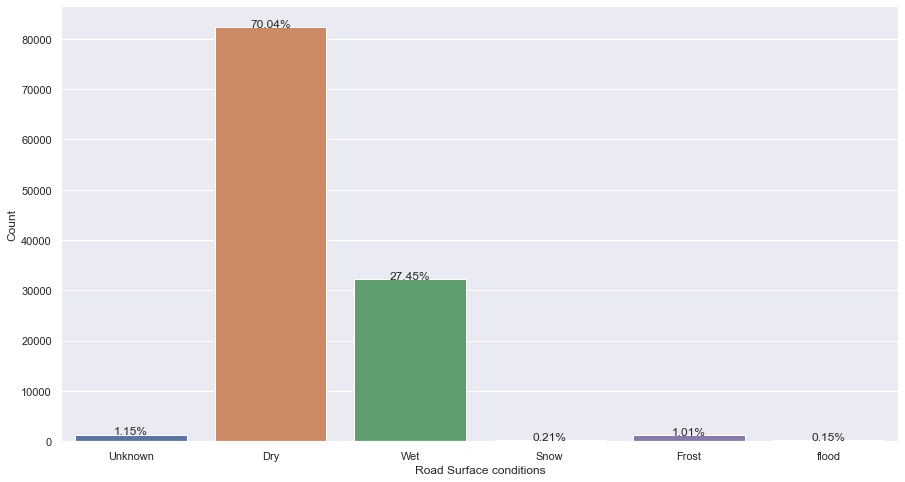

In [107]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
roadplot = sns.countplot(x='Road_Surface_Conditions',data=df_conditions)
roadplot.set(xlabel='Road Surface conditions', ylabel='Count',xticklabels=['Unknown','Dry','Wet','Snow','Frost','flood'])
for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(df_accident['decimal_time']))*100)+'%',  
      ha="center") 
plt.show()

56% of fatal accidents occured in daylight, this clearly states that darkness doesn't affect the accident rate,
most accidents occured when the road was dry, and weather seemed fine

In [108]:
def state_name(x):
    if x == 1:
        return 'Metropolitan'
    elif x == 3:
        return 'Cumbria'
    elif x == 4:
        return 'Lancashire'
    elif x == 5:
        return 'Merseyside'
    elif x == 6:
        return 'Greater Manchester'
    elif x == 7:
        return 'Cheshire'
    elif x == 10:
        return 'Northumbria'
    elif x == 11:
        return 'Durham'
    elif x == 12:
        return 'North Yorkshire'
    elif x == 13:
        return 'West Yorkshire'
    elif x == 14:
        return 'South Yorkshire'
    elif x == 16:
        return 'Humberside'
    elif x == 17:
        return 'Cleveland'
    elif x == 20:
        return 'West Midlands'
    elif x == 21:
        return 'Staffordshire'
    elif x == 22:
        return 'West Mercia'
    elif x == 23:
        return 'Warwickshire'
    elif x == 30:
        return 'Derbyshire'
    elif x == 31:
        return 'Nottinghamshire'
    elif x == 32:
        return 'Lincolnshire'
    elif x == 33:
        return 'Leicestershire'
    elif x == 34:
        return 'Northamptonshire'
    elif x == 35:
        return 'Cambridgeshire'
    elif x == 36:
        return 'Norfolk'
    elif x == 37:
        return 'Suffolk'
    elif x == 40:
        return 'Bedfordshire'
    elif x == 41:
        return 'Hertfordshire'
    elif x == 42:
        return 'Essex'
    elif x == 43:
        return 'Thames Valley'
    elif x == 44:
        return 'Hampshire'
    elif x == 45:
        return 'Surrey'
    elif x == 46:
        return 'Kent'
    elif x == 47:
        return 'Sussex'
    elif x == 48:
        return 'City of London'
    elif x == 50:
        return 'Devon and Cornwall'
    elif x == 52:
        return 'Avon and Somerset'
    elif x == 53:
        return 'Gloucestershire'
    elif x == 54:
        return 'Wiltshire'
    elif x == 55:
        return 'Dorset'
    elif x == 60:
        return 'North Wales'
    elif x == 61:
        return 'Gwent'
    elif x == 62:
        return 'South Wales'
    elif x == 63:
        return ' Dyfed-Powys'
    elif x == 91:
        return 'Northern'
    elif x == 92:
        return 'Grampian'
    elif x == 93:
        return 'Tayside'
    elif x == 94:
        return 'Fife'
    elif x == 95:
        return 'Lothian and Borders'
    elif x == 96:
        return 'Central'
    elif x == 97:
        return 'Strathclyde'
    else:
        return 'Dumfries and Galloway'

In [109]:
df_accident['Location'] = df_accident['Police_Force'].apply(lambda x : state_name(x))

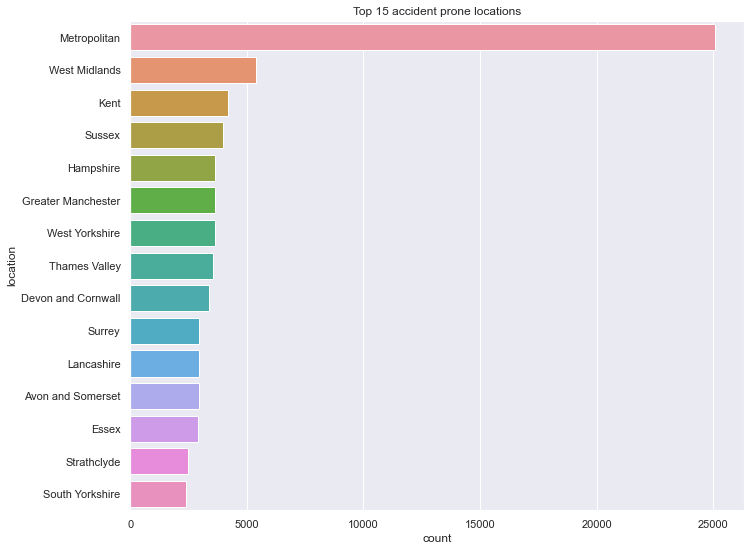

In [110]:
#top 15 accident prone locations
location_based=df_accident["Location"].value_counts().sort_values(ascending=False)[:15]
sns.set_style('white')
sns.set(rc={'figure.figsize':(11,9)})
sns.barplot(x=location_based.values, y= location_based.index)
plt.xlabel('count')
plt.ylabel('location')
plt.title("Top 15 accident prone locations")
plt.show()

## Vehicle

In [111]:
df_vehicle.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_(CC)', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile', 'Vehicle_Age_Band', 'Engine_capacity_band'],
      dtype='object')

In [112]:
df_vehicle.nunique()

Accident_Index                      117539
Vehicle_Reference                       19
Vehicle_Type                            21
Towing_and_Articulation                  7
Vehicle_Manoeuvre                       19
Vehicle_Location-Restricted_Lane        11
Junction_Location                       10
Skidding_and_Overturning                 7
Hit_Object_in_Carriageway               13
Vehicle_Leaving_Carriageway             10
Hit_Object_off_Carriageway              13
1st_Point_of_Impact                      6
Was_Vehicle_Left_Hand_Drive?             3
Journey_Purpose_of_Driver                7
Sex_of_Driver                            4
Age_of_Driver                          102
Age_Band_of_Driver                      12
Engine_Capacity_(CC)                  1056
Propulsion_Code                         11
Age_of_Vehicle                          75
Driver_IMD_Decile                       11
Driver_Home_Area_Type                    4
Vehicle_IMD_Decile                      11
Vehicle_Age

In [113]:
df_vehicle['Age_Band_of_Driver'].unique()

array([ 9, -1,  5,  7,  6,  8,  4, 11,  3, 10,  2,  1], dtype=int64)

In [114]:
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216381 entries, 0 to 216380
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Accident_Index                    216381 non-null  object 
 1   Vehicle_Reference                 216381 non-null  int64  
 2   Vehicle_Type                      216381 non-null  int64  
 3   Towing_and_Articulation           216381 non-null  int64  
 4   Vehicle_Manoeuvre                 216381 non-null  int64  
 5   Vehicle_Location-Restricted_Lane  216381 non-null  int64  
 6   Junction_Location                 216381 non-null  int64  
 7   Skidding_and_Overturning          216381 non-null  int64  
 8   Hit_Object_in_Carriageway         216381 non-null  int64  
 9   Vehicle_Leaving_Carriageway       216381 non-null  int64  
 10  Hit_Object_off_Carriageway        216381 non-null  int64  
 11  1st_Point_of_Impact               216381 non-null  i

In [115]:
df_vehicle.head(20)

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Vehicle_Age_Band,Engine_capacity_band
0,2019010128300,1,9,0,-1,-1,-1,-1,-1,-1,-1,4,-1,6,1,58,9,-1,-1,-1,2,1,2,NaN,NaN
1,2019010128300,2,9,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,6,3,-1,-1,-1,-1,-1,2,1,2,NaN,NaN
2,2019010152270,1,9,0,18,-1,0,-1,-1,-1,-1,1,-1,6,2,24,5,-1,-1,-1,3,1,3,NaN,NaN
3,2019010152270,2,9,0,18,-1,0,-1,-1,-1,-1,-1,-1,6,3,-1,-1,-1,-1,-1,6,1,6,NaN,NaN
4,2019010155191,1,9,0,3,0,1,0,0,0,0,2,1,6,1,45,7,-1,-1,-1,4,1,4,NaN,NaN
5,2019010155191,2,1,0,4,0,1,0,0,0,0,1,1,1,1,33,6,-1,-1,-1,-1,-1,-1,NaN,NaN
6,2019010155192,1,9,0,18,0,2,0,0,0,0,0,1,1,1,32,6,-1,-1,-1,3,1,3,NaN,NaN
7,2019010155194,1,9,0,18,0,1,0,0,0,0,4,1,6,2,47,8,-1,-1,-1,3,1,3,NaN,NaN
8,2019010155194,2,9,0,7,0,2,0,0,0,0,1,1,6,2,25,5,-1,-1,-1,2,1,2,NaN,NaN
9,2019010155195,1,9,0,18,0,0,0,0,0,0,1,1,6,1,20,4,-1,-1,-1,4,1,4,NaN,NaN


### Question 1b. Merging Vehicle and Accident DataSet

In [116]:
df_vehicle_accident = pd.merge(df_accident, df_vehicle, on = 'Accident_Index', how = 'inner')

In [117]:
df_vehicle_accident

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour,Location,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Vehicle_Age_Band,Engine_capacity_band
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan,1,9,0,-1,-1,-1,-1,-1,-1,-1,4,-1,6,1,58,9,-1,-1,-1,2,1,2,NaN,NaN
1,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan,2,9,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,6,3,-1,-1,-1,-1,-1,2,1,2,NaN,NaN
2,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,3,2022-09-27 21:45:00,9,E09000022,3,23,2,30,0,-1,-1,0,-1,-1,4,1,1,0,0,1,3,E01003117,2019-01-15 21:45:00,3,Tue,01,2022-09-27 21:45:00,21.750000,2019,15,21,Metropolitan,1,9,0,18,-1,0,-1,-1,-1,-1,1,-1,6,2,24,5,-1,-1,-1,3,1,3,NaN,NaN
3,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,3,2022-09-27 21:45:00,9,E09000022,3,23,2,30,0,-1,-1,0,-1,-1,4,1,1,0,0,1,3,E01003117,2019-01-15 21:45:00,3,Tue,01,2022-09-27 21:45:00,21.750000,2019,15,21,Metropolitan,2,9,0,18,-1,0,-1,-1,-1,-1,-1,-1,6,3,-1,-1,-1,-1,-1,6,1,6,NaN,NaN
4,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,3,2022-09-27 01:50:00,2,E09000007,4,504,6,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01000943,2019-01-01 01:50:00,1,Tue,01,2022-09-27 01:50:00,1.833333,2019,01,1,Metropolitan,1,9,0,3,0,1,0,0,0,0,2,1,6,1,45,7,-1,-1,-1,4,1,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175660,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,5,2022-09-27 08:46:00,917,S12000006,3,7,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-30 08:46:00,22,Thu,05,2022-09-27 08:46:00,8.766667,2019,30,8,Dumfries and Galloway,4,19,0,18,0,0,0,0,0,0,3,1,1,1,20,4,2198,2,4,5,3,5,1.0,2.0
175661,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,6,2022-09-27 15:30:00,917,S12000006,4,723,6,60,3,4,4,721,0,0,1,1,1,0,0,2,2,NaN,2019-06-21 15:30:00,25,Fri,06,2022-09-27 15:30:00,15.500000,2019,21,15,Dumfries and Galloway,1,9,0,18,0,1,0,0,0,0,1,1,6,1,33,6,1997,2,12,3,2,3,3.0,1.0
175662,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,6,2022-09-27 15:30:00,917,S12000006,4,723,6,60,3,4,4,721,0,0,1,1,1,0,0,2,2,NaN,2019-06-21 15:30:00,25,Fri,06,2022-09-27 15:30:00,15.500000,2019,21,15,Dumfries and Galloway,2,9,0,18,0,1,0,0,0,0,0,1,6,1,61,9,2967,2,5,7,3,7,1.0,2.0
175663,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,2019-06-29,7,2022-09-27 14:10:00,91

### Motorcycles

In [118]:
motorbikes = [2,3,4,5,23,97] #motorbikes

In [119]:
motorcycles = df_vehicle_accident[df_vehicle_accident['Vehicle_Type'].isin(motorbikes)]

In [120]:
motorcycles

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour,Location,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Vehicle_Age_Band,Engine_capacity_band
30,2019010155225,512750.0,180199.0,-0.376691,51.509481,1,3,2,1,2019-01-01,3,2022-09-27 00:50:00,27,E09000009,3,3005,6,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01001361,2019-01-01 00:50:00,1,Tue,01,2022-09-27 00:50:00,0.833333,2019,01,0,Metropolitan,2,4,0,13,0,8,0,0,0,0,3,1,6,1,30,6,-1,-1,-1,4,1,4,NaN,NaN
39,2019010155254,534122.0,189977.0,-0.065175,51.592686,1,3,2,1,2019-01-01,3,2022-09-27 14:18:00,31,E09000014,6,0,6,20,3,4,6,0,0,0,1,1,1,0,0,1,1,E01002080,2019-01-01 14:18:00,1,Tue,01,2022-09-27 14:18:00,14.300000,2019,01,14,Metropolitan,1,3,0,6,0,2,0,4,1,0,1,1,1,1,19,4,-1,-1,-1,2,1,2,NaN,NaN
41,2019010155255,531638.0,180380.0,-0.104600,51.507028,1,3,1,1,2019-01-01,3,2022-09-27 15:20:00,8,E09000028,3,3200,6,30,6,2,3,201,2,4,1,1,1,0,0,1,1,E01003934,2019-01-01 15:20:00,1,Tue,01,2022-09-27 15:20:00,15.333333,2019,01,15,Metropolitan,1,3,0,7,0,5,0,0,0,0,0,1,6,1,54,8,-1,-1,-1,5,1,5,NaN,NaN
46,2019010155263,538972.0,171167.0,-0.002610,51.422484,1,2,2,1,2019-01-01,3,2022-09-27 13:48:00,7,E09000023,3,21,6,30,3,4,6,0,0,0,1,1,1,0,0,1,1,E01003243,2019-01-01 13:48:00,1,Tue,01,2022-09-27 13:48:00,13.800000,2019,01,13,Metropolitan,1,4,0,4,0,1,0,0,0,0,1,1,6,1,20,4,-1,-1,-1,4,1,4,NaN,NaN
49,2019010155276,519377.0,184736.0,-0.279706,51.548898,1,2,2,1,2019-01-01,3,2022-09-27 16:39:00,28,E09000005,3,404,6,30,3,4,3,404,0,0,5,1,2,0,0,1,1,E01000620,2019-01-01 16:39:00,1,Tue,01,2022-09-27 16:39:00,16.650000,2019,01,16,Metropolitan,2,5,0,18,2,1,1,0,0,0,3,1,6,1,65,9,-1,-1,-1,-1,-1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175591,2019983112919,298215.0,576153.0,-3.595481,55.069377,98,2,1,1,2019-05-16,5,2022-09-27 12:50:00,917,S12000006,3,756,6,30,3,4,6,843,0,0,1,1,1,0,0,1,1,NaN,2019-05-16 12:50:00,20,Thu,05,2022-09-27 12:50:00,12.833333,2019,16,12,Dumfries and Galloway,1,3,0,18,0,6,0,0,0,0,4,1,6,1,38,7,124,1,3,3,1,3,1.0,1.0
175642,2019984105619,313386.0,566995.0,-3.355209,54.989987,98,3,3,1,2019-07-05,3,2022-09-27 14:50:00,917,S12000006,4,724,6,60,0,-1,-1,0,0,0,1,1,1,0,0,2,1,NaN,2019-07-05 14:50:00,27,Fri,05,2022-09-27 14:50:00,14.833333,2019,07,14,Dumfries and Galloway,1,3,0,18,0,0,0,0,0,0,3,1,5,1,21,5,124,1,5,7,2,7,1.0,1.0
175645,2019984105819,311026.0,580728.0,-3.396366,55.112939,98,1,3,1,2019-04-05,7,2022-09-27 10:55:00,917,S12000006,3,709,6,60,3,4,6,0,0,0,1,1,1,0,0,2,1,NaN,2019-04-05 10:55:00,14,Fri,05,2022-09-27 10:55:00,10.916667,2019,04,10,Dumfries and Galloway,1,5,0,13,0,1,2,0,8,11,4,1,6,1,49,8,999,1,32,6,3,6,6.0,1.0
175648,2019984106019,341523.0,579842.0,-2.918177,55.109520,98,2,1,1,2019-12-05,1,2022-09-27 11:19:00,917,S12000006,4,6318,6,60,0,-1,-1,0

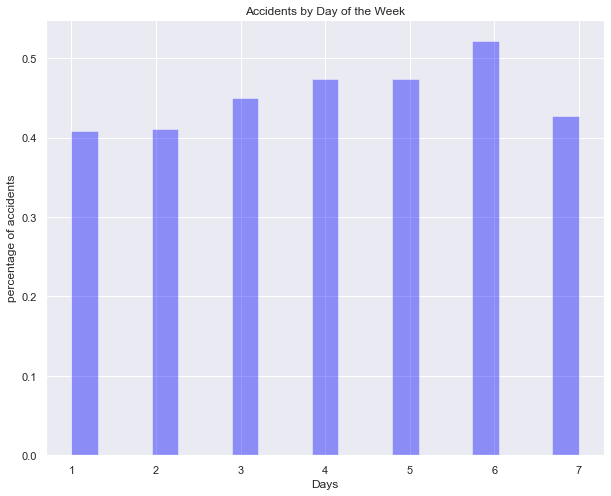

In [121]:
#Days of the Week
days=motorcycles['Day_of_Week']
fig, axs = plt.subplots(figsize=(10,8))
sns.distplot(days,kde=False,norm_hist=True,color='blue');
plt.xlabel('Days')
plt.ylabel('percentage of accidents')
plt.title('Accidents by Day of the Week')
plt.show();

<AxesSubplot:xlabel='decimal_time', ylabel='Count'>

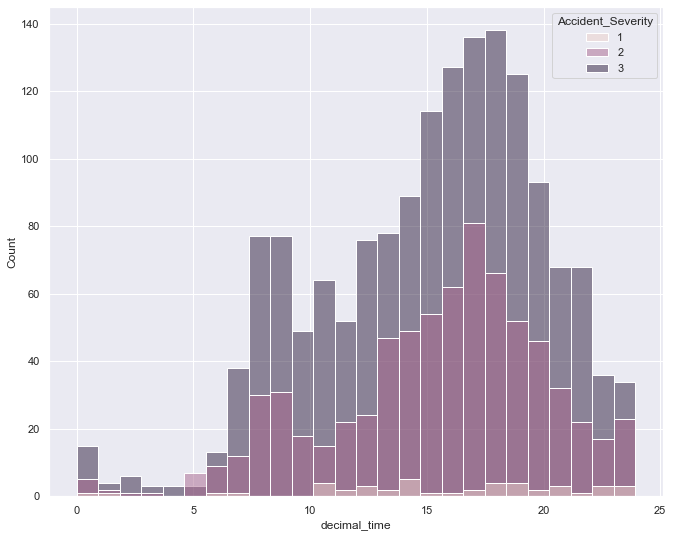

In [122]:
#Hour of the Week
#As we can see friday has the highest percentage of casualities. Lets take a closer look at Friday.
fridays_motorcycle=motorcycles[motorcycles['Day_of_Week']==6]
sns.histplot(x = 'decimal_time', data = fridays_motorcycle, hue = 'Accident_Severity')
#fridays_motorcycle['Hour'].sort_values()

<AxesSubplot:xlabel='Vehicle_Type', ylabel='count'>

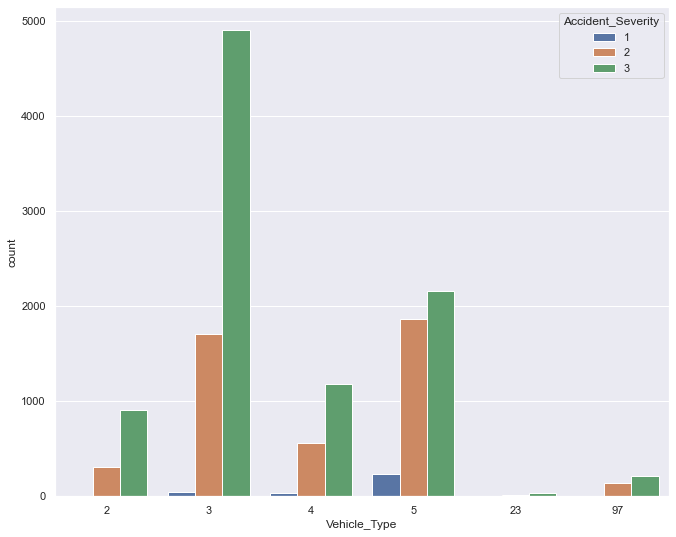

In [123]:
#motorcycle most involved in the accident.

sns.countplot(data=motorcycles, x = 'Vehicle_Type', hue = 'Accident_Severity')


## Pedestrian

In [124]:
df_casualty_accident = pd.merge(df_accident, df_casualty, on = 'Accident_Index', how = 'inner')

In [125]:
df_casualty_accident

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour,Location,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan,1,1,1,1,58,9,3,0,0,0,0,0,9,1,2
1,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan,1,2,2,2,-1,-1,3,0,0,1,0,0,9,1,5
2,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan,1,3,2,2,-1,-1,3,0,0,2,0,0,9,1,5
3,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,3,2022-09-27 21:45:00,9,E09000022,3,23,2,30,0,-1,-1,0,-1,-1,4,1,1,0,0,1,3,E01003117,2019-01-15 21:45:00,3,Tue,01,2022-09-27 21:45:00,21.750000,2019,15,21,Metropolitan,1,1,1,2,24,5,3,0,0,0,0,0,9,1,3
4,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,3,2022-09-27 01:50:00,2,E09000007,4,504,6,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01000943,2019-01-01 01:50:00,1,Tue,01,2022-09-27 01:50:00,1.833333,2019,01,1,Metropolitan,2,1,2,2,21,5,3,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128588,2019984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,1,2019-05-18,7,2022-09-27 01:00:00,917,S12000006,4,725,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-18 01:00:00,20,Sat,05,2022-09-27 01:00:00,1.000000,2019,18,1,Dumfries and Galloway,1,1,1,1,24,5,3,0,0,0,0,0,19,3,6
128589,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,5,2022-09-27 08:46:00,917,S12000006,3,7,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-30 08:46:00,22,Thu,05,2022-09-27 08:46:00,8.766667,2019,30,8,Dumfries and Galloway,1,1,1,1,22,5,3,0,0,0,0,0,19,1,1
128590,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,6,2022-09-27 15:30:00,917,S12000006,4,723,6,60,3,4,4,721,0,0,1,1,1,0,0,2,2,NaN,2019-06-21 15:30:00,25,Fri,06,2022-09-27 15:30:00,15.500000,2019,21,15,Dumfries and Galloway,2,1,1,1,61,9,3,0,0,0,0,0,9,3,7
128591,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,2019-06-29,7,2022-09-27 14:10:00,917,S12000006,6,710,6,30,3,4,6,723,0,0,1,1,1,0,0,2,2,NaN,2019-06-29 14:10:00,26,Sat,06,2022-09-27 14:10:00,14.166667,2019,29,14,Dumfries and Galloway,1,1,3,1,54,8,3,5,3,0,0,0,0,3,8


In [126]:
pedestrain = df_casualty_accident[df_casualty_accident['Casualty_Class'] == 3]

In [127]:
pedestrain

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour,Location,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
5,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,2019-01-01,3,2022-09-27 01:20:00,2,E09000007,4,510,6,20,3,4,4,510,0,0,4,1,1,0,0,1,1,E01000973,2019-01-01 01:20:00,1,Tue,01,2022-09-27 01:20:00,1.333333,2019,01,1,Metropolitan,1,1,3,1,68,10,2,5,4,0,0,0,0,1,4
11,2019010155196,532424.0,164886.0,-0.099071,51.367605,1,3,1,1,2019-01-01,3,2022-09-27 01:35:00,20,E09000008,3,235,6,30,6,2,4,271,0,5,4,1,1,0,0,1,1,E01001043,2019-01-01 01:35:00,1,Tue,01,2022-09-27 01:35:00,1.583333,2019,01,1,Metropolitan,1,1,3,1,40,7,3,1,3,0,0,0,0,1,4
19,2019010155209,543649.0,186237.0,0.070738,51.556734,1,3,1,1,2019-01-01,3,2022-09-27 01:15:00,14,E09000026,3,118,3,20,3,2,6,0,0,4,4,1,1,0,0,1,1,E01003689,2019-01-01 01:15:00,1,Tue,01,2022-09-27 01:15:00,1.250000,2019,01,1,Metropolitan,1,1,3,1,23,5,3,1,1,0,0,0,0,1,8
20,2019010155210,537356.0,183448.0,-0.021065,51.533238,1,1,1,1,2019-01-01,3,2022-09-27 03:00:00,5,E09000030,3,12,3,40,0,-1,-1,0,0,0,6,1,1,0,0,1,1,E01032764,2019-01-01 03:00:00,1,Tue,01,2022-09-27 03:00:00,3.000000,2019,01,3,Metropolitan,1,1,3,1,24,5,1,5,1,0,0,0,0,1,10
21,2019010155216,532724.0,185103.0,-0.087182,51.549218,1,3,1,1,2019-01-01,3,2022-09-27 02:45:00,3,E09000019,3,105,3,20,9,3,6,0,0,4,4,1,1,0,0,1,1,E01002776,2019-01-01 02:45:00,1,Tue,01,2022-09-27 02:45:00,2.750000,2019,01,2,Metropolitan,1,1,3,1,38,7,3,5,3,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128543,2019983114119,297464.0,576134.0,-3.607229,55.069052,98,2,1,1,2019-01-06,7,2022-09-27 22:40:00,917,S12000006,3,781,2,30,3,4,3,780,0,0,4,1,1,0,2,1,1,NaN,2019-01-06 22:40:00,1,Sun,06,2022-09-27 22:40:00,22.666667,2019,01,22,Dumfries and Galloway,1,1,3,1,64,9,2,5,1,0,0,0,0,1,4
128548,2019983115619,296071.0,577414.0,-3.629501,55.080260,98,3,1,1,2019-06-19,4,2022-09-27 13:55:00,917,S12000006,6,815,6,20,0,-1,-1,0,0,0,1,1,1,0,0,1,2,NaN,2019-06-19 13:55:00,25,Wed,06,2022-09-27 13:55:00,13.916667,2019,19,13,Dumfries and Galloway,1,1,3,1,0,1,3,9,8,0,0,0,0,-1,-1
128566,2019984104219,313523.0,582066.0,-3.357641,55.125401,98,2,1,1,2019-05-04,6,2022-09-27 13:15:00,917,S12000006,4,723,6,30,0,-1,-1,0,0,0,1,1,1,0,0,1,1,NaN,2019-05-04 13:15:00,18,Sat,04,2022-09-27 13:15:00,13.250000,2019,05,13,Dumfries and Galloway,1,1,3,2,75,10,2,6,9,0,0,0,0,2,4
128567,2019984104419,331608.0,566975.0,-3.070480,54.992647,98,3,1,1,2019-09-04,3,2022-09-27 02:30:00,917,S12000006,5,67,6,30,9,4,6,180,0,0,4,1,1,0,0,1,1,NaN,2019-09-04 02:30:00,36,Wed,04,2022-09-27 02:30:00,2.500000,2019,09,2,Dumfries and Galloway,1,1,3,1,16,4,3,6,9,0,0,0,0,2,6


Days

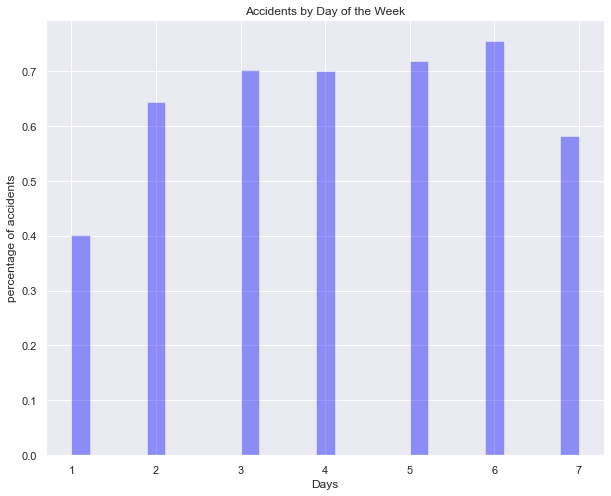

In [128]:
#Days of the Week
days=pedestrain['Day_of_Week']
fig, axs = plt.subplots(figsize=(10,8))
sns.distplot(days,kde=False,norm_hist=True,color='blue');
plt.xlabel('Days')
plt.ylabel('percentage of accidents')
plt.title('Accidents by Day of the Week')
plt.show();

<AxesSubplot:xlabel='decimal_time', ylabel='Count'>

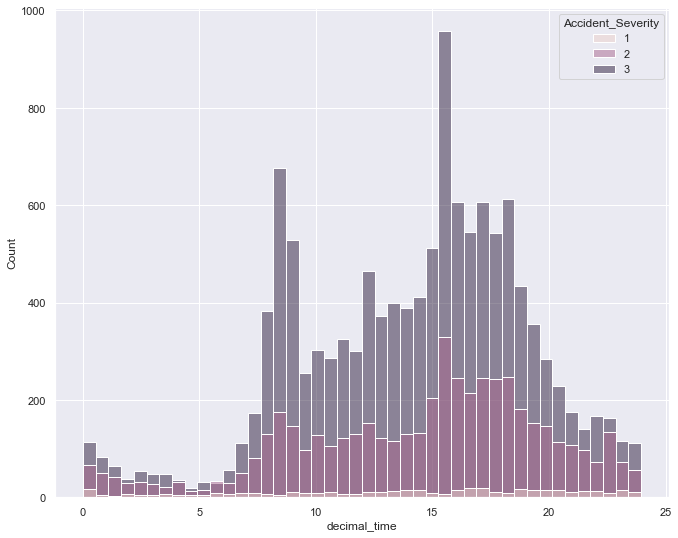

In [129]:
#Hour of the Week
#As we can see friday has the highest percentage of casualities. Lets take a closer look at Friday.
fridays_pedestrain=pedestrain[pedestrain['Day_of_Week']==6]
sns.histplot(x = 'decimal_time', data = pedestrain, hue = 'Accident_Severity')

In [130]:
pedestrain['decimal_time'].mode()

0    15.5
dtype: float64

In [131]:
#who are the pedestrains most affected.

# K.Means Clustering

In [132]:
import numpy as np

In [133]:
from sklearn.cluster import KMeans

In [134]:
df2 = df_accident[['Latitude','Longitude']]

In [135]:
# x = df_accident['Latitude']
# y = df_accident['Longitude']
# df2 = pd.DataFrame(np.c_[x,y], columns = ['Latitude', 'Longitude'])

In [136]:
distortions = []  #https://predictivehacks.com/k-means-elbow-method-code-for-python/

In [137]:
K = range(2,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df2)
    distortions.append(kmeanModel.inertia_)

Plotting the distortions of K-Means

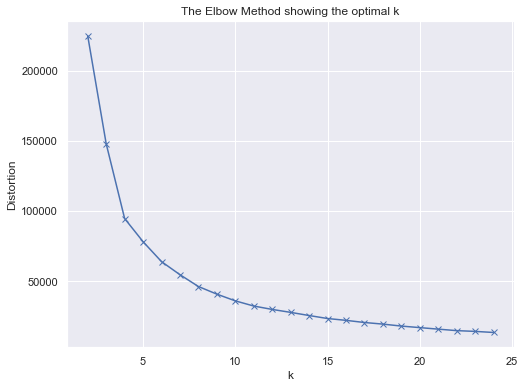

In [138]:
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [139]:
df2

,Latitude,Longitude
0,51.508057,-0.153842
1,51.436208,-0.127949
2,51.526795,-0.124193
3,51.546387,-0.191044
4,51.541121,-0.200064
...,...,...
117531,55.047323,-3.368899
117532,55.215407,-2.983499
117533,54.991685,-3.274645
117534,55.148292,-2.997491


In [140]:
#Use elbow method to determine the best clusters

In [141]:
kmeans = KMeans(n_clusters = 4) #use 12

In [142]:
kmeans.fit(df2)

KMeans(n_clusters=4)

In [143]:
labels = kmeans.predict(df2)

In [144]:
centroids = kmeans.cluster_centers_

In [145]:
centroids #Use this for your folium

array([[55.98329582, -3.70352995],
       [51.28035181, -3.1145682 ],
       [53.38914134, -1.79466736],
       [51.56312723, -0.11728002]])

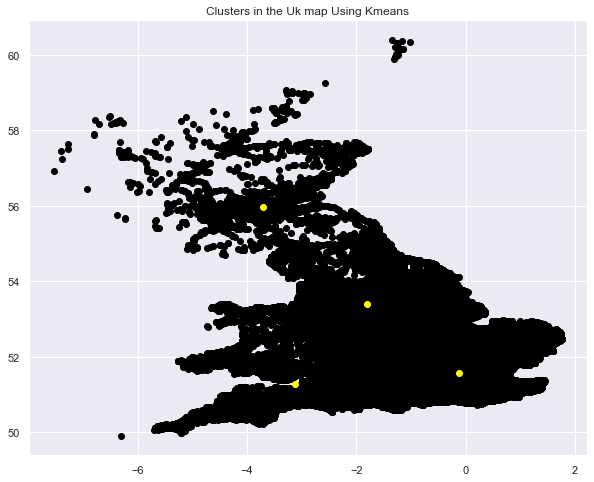

In [146]:
fig = plt.figure(figsize = (10,8))
colors = map(lambda x : colmap[x+1], labels)
plt.scatter(x = df2['Longitude'], y = df2['Latitude'], color = 'black')
plt.scatter(centroids[:,1], centroids[:,0], color = 'yellow')
plt.title('Clusters in the Uk map Using Kmeans')
plt.show()

# Merged Data

In [147]:
merging = pd.merge(df_casualty, df_vehicle, on = ['Accident_Index','Vehicle_Reference'], how = 'inner')

In [148]:
merged_data = pd.merge(merging, df_accident, on = 'Accident_Index', how = 'inner')

In [149]:
merged_data

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Vehicle_Age_Band,Engine_capacity_band,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Date_Time,Week,Day_name,Month,converted_time,decimal_time,Year,Day,Hour,Location
0,2019010128300,1,1,1,1,58,9,3,0,0,0,0,0,9,1,2,9,0,-1,-1,-1,-1,-1,-1,-1,4,-1,6,1,58,9,-1,-1,-1,2,1,2,NaN,NaN,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan
1,2019010128300,1,2,2,2,-1,-1,3,0,0,1,0,0,9,1,5,9,0,-1,-1,-1,-1,-1,-1,-1,4,-1,6,1,58,9,-1,-1,-1,2,1,2,NaN,NaN,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan
2,2019010128300,1,3,2,2,-1,-1,3,0,0,2,0,0,9,1,5,9,0,-1,-1,-1,-1,-1,-1,-1,4,-1,6,1,58,9,-1,-1,-1,2,1,2,NaN,NaN,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,2,2022-09-27 17:50:00,1,E09000033,3,4202,1,30,1,2,3,4202,0,5,1,1,1,0,0,1,3,E01004762,2019-02-18 17:50:00,8,Mon,02,2022-09-27 17:50:00,17.833333,2019,18,17,Metropolitan
3,2019010152270,1,1,1,2,24,5,3,0,0,0,0,0,9,1,3,9,0,18,-1,0,-1,-1,-1,-1,1,-1,6,2,24,5,-1,-1,-1,3,1,3,NaN,NaN,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,3,2022-09-27 21:45:00,9,E09000022,3,23,2,30,0,-1,-1,0,-1,-1,4,1,1,0,0,1,3,E01003117,2019-01-15 21:45:00,3,Tue,01,2022-09-27 21:45:00,21.750000,2019,15,21,Metropolitan
4,2019010155191,2,1,2,2,21,5,3,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,0,1,1,1,1,33,6,-1,-1,-1,-1,-1,-1,NaN,NaN,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,3,2022-09-27 01:50:00,2,E09000007,4,504,6,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01000943,2019-01-01 01:50:00,1,Tue,01,2022-09-27 01:50:00,1.833333,2019,01,1,Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109513,2019984106919,1,1,1,1,24,5,3,0,0,0,0,0,19,3,6,19,0,17,0,0,1,0,1,0,1,1,1,1,24,5,1997,2,14,6,3,6,3.0,1.0,312635.0,573392.0,-3.368899,55.047323,98,3,1,1,2019-05-18,7,2022-09-27 01:00:00,917,S12000006,4,725,6,60,0,-1,-1,0,0,0,1,1,2,0,0,2,1,NaN,2019-05-18 01:00:00,20,Sat,05,2022-09-27 01:00:00,1.000000,2019,18,1,Dumfries and Galloway
109514,2019984107019,1,1,1,1,22,5,3,0,0,0,0,0,19,1,1,19,4,18,0,0,0,0,0,0,3,1,1,1,22,5,2143,2,1,1,1,1,1.0,2.0,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,5,2022-09-27 08:46:00,917,S12000006,3,7,6

#### Missng columns

In [150]:
def change_values(x):
    if x == 1:
        return 2
    elif x == 2:
        return 2
    elif x ==3:
        return 3
        
        

In [151]:
merged_data['Accident_Severity'] = merged_data['Accident_Severity'].apply(change_values)

In [152]:
merged_data['Accident_Severity'].unique()

array([3, 2], dtype=int64)

In [153]:
merged_data = merged_data.replace(-1, np.NaN)

In [154]:
merged_data.isnull().sum()

Accident_Index          0
Vehicle_Reference       0
Casualty_Reference      0
Casualty_Class          0
Sex_of_Casualty       445
                     ... 
decimal_time            0
Year                    0
Day                     0
Hour                    0
Location                0
Length: 80, dtype: int64

In [155]:
merged_data = merged_data.dropna()

In [156]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32651 entries, 144 to 101919
Data columns (total 80 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Accident_Index                               32651 non-null  object        
 1   Vehicle_Reference                            32651 non-null  int64         
 2   Casualty_Reference                           32651 non-null  int64         
 3   Casualty_Class                               32651 non-null  int64         
 4   Sex_of_Casualty                              32651 non-null  float64       
 5   Age_of_Casualty                              32651 non-null  float64       
 6   Age_Band_of_Casualty                         32651 non-null  float64       
 7   Casualty_Severity                            32651 non-null  int64         
 8   Pedestrian_Location                          32651 non-null  float64     

# Dataset Balancing

In [157]:
from sklearn.utils import resample

In [158]:
#severity1 = merged_data[merged_data['Accident_Severity']==1]

In [159]:
severity2 = merged_data[merged_data['Accident_Severity']==2]

In [160]:
severity3 = merged_data[merged_data['Accident_Severity']==3]

In [161]:
#len(severity1)

In [162]:
len(severity2)

6666

In [163]:
len(severity3)

25985

In [164]:
severity2_resample = resample(severity2, replace = True, n_samples=25985, random_state=143)

In [165]:
#severity3_resample = resample(severity3, replace = True, n_samples=6666, random_state=143)

In [166]:
df2 = pd.concat([severity3,severity2_resample])

In [167]:
#df2 = pd.concat([severity2,severity3_resample])

In [168]:
df2['Accident_Severity'].unique()

array([3, 2], dtype=int64)

In [169]:
merged_data = df2

# Feature Selection

In [170]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

In [171]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51970 entries, 144 to 91090
Data columns (total 80 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Accident_Index                               51970 non-null  object        
 1   Vehicle_Reference                            51970 non-null  int64         
 2   Casualty_Reference                           51970 non-null  int64         
 3   Casualty_Class                               51970 non-null  int64         
 4   Sex_of_Casualty                              51970 non-null  float64       
 5   Age_of_Casualty                              51970 non-null  float64       
 6   Age_Band_of_Casualty                         51970 non-null  float64       
 7   Casualty_Severity                            51970 non-null  int64         
 8   Pedestrian_Location                          51970 non-null  float64      

In [172]:
merged_data.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference',
       'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
       'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location',
       'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger',
       'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
       'Casualty_Home_Area_Type', 'Casualty_IMD_Decile', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_(CC)', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile', 'Vehicle_Age_Band', 'Engine_cap

In [173]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from numpy import array 

In [174]:
X = merged_data.drop(['Accident_Severity','Date','Day_of_Week','Time','Local_Authority_(Highway)',
                       'Date_Time','Week','Day_name','Month','converted_time', 'decimal_time', 'Year', 'Day', 'Hour', 
                      'Location','Casualty_Severity', 'LSOA_of_Accident_Location','Location_Easting_OSGR', 
                      'Location_Northing_OSGR','Longitude', 'Latitude', 'Vehicle_Age_Band',
                      'Engine_capacity_band','Accident_Index',], axis = 1)
#, 'Local_Authority_(District)', 'Age_of_Casualty', 'Age_of_Driver',
Y = merged_data['Accident_Severity']

In [175]:
X.columns

Index(['Vehicle_Reference', 'Casualty_Reference', 'Casualty_Class',
       'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Band_of_Casualty',
       'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
       'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker',
       'Casualty_Type', 'Casualty_Home_Area_Type', 'Casualty_IMD_Decile',
       'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_(CC)', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile', 'Police_Force', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Local_A

In [176]:
from sklearn.model_selection import train_test_split

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 7)

In [178]:
from sklearn.linear_model import LogisticRegression 
#https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
from sklearn.feature_selection import SelectFromModel

In [179]:
from sklearn.preprocessing import StandardScaler
#https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

In [180]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [181]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2', solver = 'liblinear', random_state = 10))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=1, random_state=10,
                                             solver='liblinear'))

In [182]:
sel_.get_support()

array([ True,  True,  True,  True,  True, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False,  True, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True, False, False, False, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True])

In [183]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 56
selected features: 21
features with coefficients shrank to zero: 0


In [184]:
selected_feat

Index(['Vehicle_Reference', 'Casualty_Reference', 'Casualty_Class',
       'Sex_of_Casualty', 'Age_of_Casualty', 'Car_Passenger', 'Casualty_Type',
       'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
       'Vehicle_Leaving_Carriageway', '1st_Point_of_Impact', 'Sex_of_Driver',
       'Age_of_Driver', 'Age_Band_of_Driver', 'Engine_Capacity_(CC)',
       'Police_Force', 'Number_of_Casualties', 'Speed_limit', '2nd_Road_Class',
       'Light_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident'],
      dtype='object')

# Feature Engineering

In [185]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [186]:
! pip install scipy

In [187]:
x = merged_data.loc[:, selected_feat]
y = merged_data.loc[:,['Accident_Severity']]

In [188]:
from scipy.stats import zscore
df_num_scaled=x.apply(zscore)
df_num_scaled.head()

,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Car_Passenger,Casualty_Type,Vehicle_Manoeuvre,Skidding_and_Overturning,Vehicle_Leaving_Carriageway,1st_Point_of_Impact,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Police_Force,Number_of_Casualties,Speed_limit,2nd_Road_Class,Light_Conditions,Did_Police_Officer_Attend_Scene_of_Accident
144,-0.819964,-0.433053,-0.686774,-0.843210,0.406288,-0.448306,0.142522,-0.777892,-0.30696,-0.317135,1.040476,-0.696576,0.372530,0.532687,0.161958,-1.19904,0.672263,-1.316217,-1.811649,1.235032,-0.439956
145,-0.819964,0.494982,0.678629,-0.843210,-0.577757,3.052326,0.142522,-0.777892,-0.30696,-0.317135,1.040476,-0.696576,0.372530,0.532687,0.161958,-1.19904,0.672263,-1.316217,-1.811649,1.235032,-0.439956
146,-0.819964,1.423016,0.678629,1.185944,-0.577757,3.052326,0.142522,-0.777892,-0.30696,-0.317135,1.040476,-0.696576,0.372530,0.532687,0.161958,-1.19904,0.672263,-1.316217,-1.811649,1.235032,-0.439956
315,-0.819964,-0.433053,-0.686774,1.185944,0.750704,-0.448306,-0.796817,-1.836285,-0.30696,-0.317135,0.171769,1.424164,0.771311,0.532687,-1.165544,-1.19904,-0.573659,-1.316217,0.600345,1.235032,-0.439956
419,-0.819964,-0.433053,-0.686774,-0.843210,-0.134936,-0.448306,0.330390,0.809696,-0.30696,-0.317135,-0.696938,-0.696576,-0.254125,0.001299,0.158786,-1.19904,-0.573659,-1.316217,0.600345,1.235032,-0.439956


In [189]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_num_scaled)
p_value

0.0

For our dataset p_value is 0.0 which is less than 0.05. Hence we can reject the Null Hypothesis and agree that there is at least one pair of variables in the data which are correlated. Hence, PCA is recommended.

In [190]:
cov_matrix = np.cov(df_num_scaled.T)
print('Covariance Matrix n%s', cov_matrix)

Covariance Matrix n%s [[ 1.00001924e+00  1.99560641e-01 -2.76513133e-01  2.36065923e-02
  -1.06491210e-02  6.29653509e-02  1.74914040e-01  4.10371088e-02
  -7.91396314e-02 -9.22450299e-02  6.32315455e-02  4.64907728e-02
  -7.97783049e-04  1.00278358e-02 -6.08575472e-02  1.39265231e-02
   1.07113769e-01  8.09548198e-02 -1.01914252e-02 -6.32160144e-02
   4.99035110e-02]
 [ 1.99560641e-01  1.00001924e+00  1.32499432e-01  9.50298843e-02
  -5.86905889e-02  3.98880020e-01  1.54918429e-01  3.79254169e-02
   7.17983535e-02  1.93607212e-02  3.82259434e-02 -1.10376130e-02
   2.41007166e-02  2.54336990e-02  1.28646780e-01  4.28755774e-02
   7.52931877e-01  1.39933866e-01  1.35996148e-02  6.32090833e-02
  -1.90521823e-02]
 [-2.76513133e-01  1.32499432e-01  1.00001924e+00  1.49467257e-01
  -2.83899843e-02  3.04147290e-01 -4.06396885e-01 -5.09366612e-02
  -9.88152155e-02 -7.29577952e-02 -2.62327017e-02 -3.13091686e-02
   5.61301378e-02  5.73377588e-02  2.27552686e-01 -8.20742661e-02
   3.12250222e-0

In [191]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('n Eigen Values n %s', eig_vals)
print('n')
print('Eigen Vectors n %s', eig_vecs)

n Eigen Values n %s [2.75186519 2.34156668 1.82095816 1.70646248 0.01788822 0.22168667
 0.29427767 0.32226108 0.3752448  1.29409947 1.19126763 0.63380055
 0.68067932 0.74012425 1.06289797 1.04200892 0.99602841 0.82377918
 0.92737214 0.89288475 0.86325053]
n
Eigen Vectors n %s [[-1.72056215e-02 -1.78690696e-01 -1.64956172e-01 -2.89343438e-01
  -7.60443198e-03 -1.45788590e-01 -7.53439273e-02 -1.06139888e-01
   2.35530516e-03  3.40676758e-01  3.58532727e-01  4.53503562e-02
  -6.72576501e-01  1.53825329e-01  3.48492207e-02 -7.91140135e-02
   2.37552794e-01  9.88590001e-02  5.44049622e-02  1.31253061e-01
   4.50973252e-02]
 [-3.43856091e-02 -5.42568911e-01  9.84154931e-03  1.82317577e-01
  -1.93560353e-03  7.08540961e-01 -1.18355242e-01 -5.83235983e-02
   1.28104118e-02  1.16742370e-01  1.53992641e-01 -1.48493491e-01
   8.09091670e-02  2.10891399e-01  6.74026977e-02  1.62809197e-02
   1.21003793e-02 -1.04374743e-01  4.06716858e-02 -1.46386409e-01
   4.63263226e-02]
 [-3.73332223e-02 -3.1242

In [192]:
! pip install factor_analyzer

In [193]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Variance Explainedn", var_exp)
print("n")
print("Cumulative Variance Explainedn", cum_var_exp)

Variance Explainedn [13.103867818428878, 11.150102969811945, 8.671062474312203, 8.12585544768437, 6.1622598723874, 5.672593838116196, 5.061321498927803, 4.961851774634298, 4.742901176264643, 4.415972829413727, 4.251750347001972, 4.110637705403836, 3.922682535434914, 3.524333394333495, 3.241267737924141, 3.0180397637701386, 1.786845622089929, 1.5345470326250485, 1.401295296162008, 1.05563051548924, 0.08518034978381833]
n
Cumulative Variance Explainedn [ 13.10386782  24.25397079  32.92503326  41.05088871  47.21314858
  52.88574242  57.94706392  62.90891569  67.65181687  72.0677897
  76.31954005  80.43017775  84.35286029  87.87719368  91.11846142
  94.13650118  95.92334681  97.45789384  98.85918913  99.91481965
 100.        ]


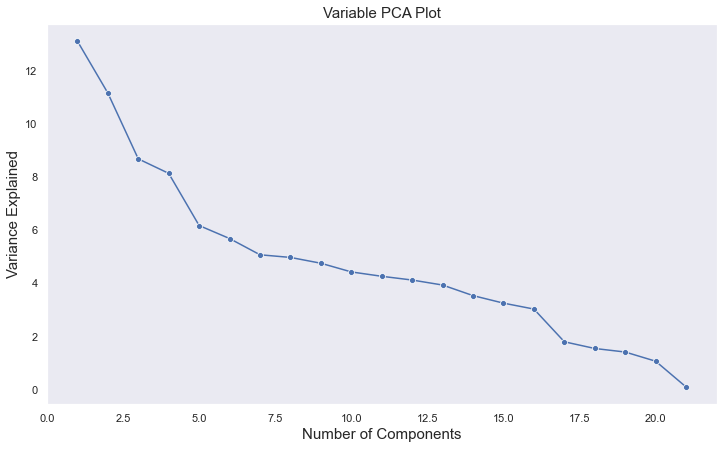

In [194]:
plt.figure(figsize=(12,7))
sns.lineplot(y=var_exp,x=range(1,len(var_exp)+1),marker='o')
plt.xlabel('Number of Components',fontsize=15)
plt.ylabel('Variance Explained',fontsize=15)
plt.title('Variable PCA Plot',fontsize=15)
plt.grid()
plt.show()

In [195]:
# Using scikit learn PCA here. It does all the above steps and maps data to PCA dimensions in oneshot
from sklearn.decomposition import PCA
# NOTE - we are generating only 8 PCA dimensions (dimensionality reduction from 16 to 5)
pca = PCA(n_components=8, random_state=70)
df_pca = pca.fit_transform(df_num_scaled)
df_pca.transpose() # Component output

array([[ 0.40473567, -0.09828587,  0.22252579, ...,  1.16023471,
         1.8529224 ,  1.88320851],
       [-0.66227228,  1.38490873,  2.25162416, ..., -0.79406026,
        -0.39085998, -0.35842055],
       [ 0.29182843, -1.24680993, -2.10697235, ..., -1.47206077,
         2.31030413, -2.28130286],
       ...,
       [-1.82503591, -1.68332013, -1.53849017, ...,  0.17245691,
        -0.11379543, -1.76999964],
       [-0.03196483, -0.77574828, -0.65094881, ..., -0.73537937,
         0.53601704,  2.82636348],
       [ 0.37439493,  0.1263481 ,  0.38377736, ..., -1.72694936,
        -1.79992222, -1.81078701]])

In [196]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_num_scaled)
kmo_model
#https://www.analyticsvidhya.com/blog/2021/09/pca-and-its-underlying-mathematical-principles/

0.5942705044623093

In [197]:
x = merged_data.loc[:, selected_feat].values
y = merged_data.loc[:,['Accident_Severity']].values
x = StandardScaler().fit_transform(x)

x

array([[-0.81996389, -0.43305307, -0.68677378, ..., -1.8116485 ,
         1.2350317 , -0.43995599],
       [-0.81996389,  0.49498157,  0.67862917, ..., -1.8116485 ,
         1.2350317 , -0.43995599],
       [-0.81996389,  1.42301622,  0.67862917, ..., -1.8116485 ,
         1.2350317 , -0.43995599],
       ...,
       [-0.81996389, -0.43305307,  2.04403212, ...,  0.60034526,
        -0.62207196, -0.43995599],
       [-0.81996389, -0.43305307, -0.68677378, ..., -0.20365266,
        -0.62207196, -0.43995599],
       [-0.81996389, -0.43305307,  2.04403212, ..., -1.00765058,
         1.2350317 , -0.43995599]])

In [198]:
#Now that we've standardized the values of the variables, we will apply the PCA.

pca = PCA(n_components=7)
principalComponents = pca.fit_transform(x)
New_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7'])

New_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.404722,-0.662492,0.292867,-0.714842,1.638910,-1.823143,-0.030504
1,-0.098465,1.385293,-1.247828,-1.932178,1.569285,-1.681011,-0.769596
2,0.222060,2.251789,-2.108442,-1.436773,1.027450,-1.533614,-0.650699
3,0.962030,-1.427613,-1.596190,0.876580,-0.271980,-0.116670,-0.527684
4,-0.802504,-1.343385,0.499811,-1.010250,0.498410,0.304545,1.338284
...,...,...,...,...,...,...,...
51965,-2.642903,-1.144100,-1.912872,-1.199982,-1.004730,0.403025,0.193794
51966,-2.232587,-0.424199,0.500107,0.499466,1.063017,0.833972,0.901866
51967,1.160471,-0.795912,-1.466767,-1.081293,-1.516911,0.173741,-0.753488
51968,1.852911,-0.390808,2.310264,-0.486553,-1.283590,-0.113918,0.534950


In [199]:
#We will recombine the principal components with the targets now.

# Final_df = pd.concat([New_df, merged_data['Accident_Severity']], axis = 1)

# Final_df

In [200]:
#Let's see how much of the variance is explained.

pca.explained_variance_ratio_


array([0.13103868, 0.11150102, 0.08671049, 0.08125854, 0.06162208,
       0.05672578, 0.0506128 ])

In [201]:
print(abs(pca.components_))

[[1.72118992e-02 3.43855094e-02 3.73555856e-02 1.42345552e-01
  4.96612789e-01 2.77919925e-02 6.69696856e-02 9.19274949e-02
  7.82738622e-02 3.49065120e-02 3.19183830e-02 7.94580137e-02
  5.69009206e-01 5.67936299e-01 1.61075934e-01 5.41325859e-02
  3.38535607e-02 7.10903687e-02 2.01157066e-02 1.41253651e-01
  9.88741232e-03]
 [1.78676422e-01 5.42579805e-01 3.12190176e-02 1.78999397e-01
  1.12880246e-01 3.97090518e-01 2.78139161e-01 2.19374766e-02
  6.89805440e-02 6.51918276e-02 7.48825576e-02 1.00545845e-01
  4.52779691e-02 4.27161844e-02 1.39800682e-01 7.34818185e-02
  5.30547696e-01 2.22094243e-01 3.68382887e-02 8.18114102e-02
  6.31350456e-04]
 [1.65026544e-01 9.87581656e-03 4.90726982e-01 4.19809291e-01
  1.17472899e-01 2.12638980e-01 2.60678808e-01 2.20142109e-01
  2.66734687e-01 2.11364328e-01 2.28234773e-02 3.29767470e-01
  6.13512474e-02 5.50907472e-02 1.17399629e-01 1.47105244e-01
  5.04647282e-02 3.00679214e-01 1.51457981e-02 7.43900045e-02
  1.18976397e-01]
 [2.89358695e-01

In [202]:
#number of components
n_pcs = pca.components_.shape[0]

In [203]:
#Get the index of the most important feature on each component
#LIST COMPREHENSION
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [204]:
initial_feature_names = ['Vehicle_Reference', 'Casualty_Class', 'Sex_of_Casualty',
                         'Age_of_Casualty', 'Age_Band_of_Casualty', 'Car_Passenger',
                         'Casualty_Type', 'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
                         'Vehicle_Leaving_Carriageway', '1st_Point_of_Impact', 'Sex_of_Driver',
                         'Age_of_Driver', 'Age_of_Vehicle', 'Number_of_Casualties',
                         'Speed_limit', '2nd_Road_Class', 'Light_Conditions',
                         'Did_Police_Officer_Attend_Scene_of_Accident']

In [205]:
#Get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [206]:
#List Comprehension
dic = {'PC {}'.format(i): most_important_names[i] for i in range(n_pcs)}

In [207]:
#Build the Dataframe.
df = pd.DataFrame(dic.items())

In [208]:
df

,0,1
0,PC 0,Age_of_Driver
1,PC 1,Casualty_Class
2,PC 2,Sex_of_Casualty
3,PC 3,Sex_of_Driver
4,PC 4,Vehicle_Leaving_Carriageway
5,PC 5,Did_Police_Officer_Attend_Scene_of_Accident
6,PC 6,Number_of_Casualties


# Model Building

In [209]:
x = merged_data.loc[:, selected_feat].values
y = merged_data.loc[:,['Accident_Severity']].values

In [210]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((36379, 21), (15591, 21))

### Naive Bayes Classifier

In [211]:
from sklearn.naive_bayes import GaussianNB

In [212]:
classifierNB = GaussianNB()

In [213]:
%%time
classifierNB.fit(X_train, y_train)

Wall time: 32.4 ms


GaussianNB()

In [214]:
y_predNB  =  classifierNB.predict(X_test)

In [215]:
y_predNB

array([2, 2, 3, ..., 3, 3, 2], dtype=int64)

In [216]:
from sklearn.metrics import confusion_matrix,accuracy_score
cmNB = confusion_matrix(y_test, y_predNB)
acNB = accuracy_score(y_test,y_predNB)

In [217]:
print(classification_report(y_test,y_predNB))

              precision    recall  f1-score   support

           2       0.67      0.46      0.55      7823
           3       0.59      0.77      0.67      7768

    accuracy                           0.62     15591
   macro avg       0.63      0.62      0.61     15591
weighted avg       0.63      0.62      0.61     15591



In [218]:
cmNB

array([[3623, 4200],
       [1761, 6007]], dtype=int64)

In [219]:
acNB

0.617664036944391

In [220]:
round(classifierNB.score(X_train,y_train)*100,2)

61.92

### Decision Tree Classifier

In [221]:
from sklearn.tree import DecisionTreeClassifier

In [222]:
classifierDT = DecisionTreeClassifier()

In [223]:
%%time
classifierDT.fit(X_train, y_train)

Wall time: 456 ms


DecisionTreeClassifier()

In [224]:
y_predDT  =  classifierDT.predict(X_test)

In [225]:
from sklearn.metrics import confusion_matrix,accuracy_score
cmDT = confusion_matrix(y_test, y_predDT)
acDT = accuracy_score(y_test,y_predDT)

In [226]:
print(classification_report(y_test,y_predDT))

              precision    recall  f1-score   support

           2       0.84      0.97      0.90      7823
           3       0.96      0.82      0.88      7768

    accuracy                           0.89     15591
   macro avg       0.90      0.89      0.89     15591
weighted avg       0.90      0.89      0.89     15591



In [227]:
cmDT

array([[7570,  253],
       [1434, 6334]], dtype=int64)

In [228]:
acDT

0.8917965492912577

In [229]:
round(classifierDT.score(X_train,y_train)*100,2)

99.98

### Random Forest Classifier

In [230]:
from sklearn.ensemble import RandomForestClassifier

In [231]:
classifierRF = RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200, n_jobs=-1, random_state=42)

In [232]:
%%time
classifierRF.fit(X_train, y_train)

Wall time: 6.01 s


RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [233]:
y_predRF  =  classifierRF.predict(X_test)

In [234]:
from sklearn.metrics import confusion_matrix,accuracy_score
cmRF = confusion_matrix(y_test, y_predRF)
acRF = accuracy_score(y_test,y_predRF)

In [235]:
print(classification_report(y_test,y_predRF))

              precision    recall  f1-score   support

           2       0.82      0.87      0.85      7823
           3       0.86      0.81      0.84      7768

    accuracy                           0.84     15591
   macro avg       0.84      0.84      0.84     15591
weighted avg       0.84      0.84      0.84     15591



In [236]:
cmRF

array([[6840,  983],
       [1472, 6296]], dtype=int64)

In [237]:
acRF

0.8425373612981848

In [238]:
round(classifierRF.score(X_train,y_train)*100,2)

91.87

In [239]:
classifierRF.predict_proba(X_test)

array([[0.92652686, 0.07347314],
       [0.90465906, 0.09534094],
       [0.21131999, 0.78868001],
       ...,
       [0.2626355 , 0.7373645 ],
       [0.02125709, 0.97874291],
       [0.8175948 , 0.1824052 ]])

## Logistic Regression

In [240]:
%%time
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

Wall time: 744 ms


LogisticRegression()

In [241]:
y_predLR = logreg.predict(X_test)

In [242]:
from sklearn.metrics import confusion_matrix,accuracy_score
cmLR = confusion_matrix(y_predLR,y_test)
acLR = accuracy_score(y_predLR,y_test)

In [243]:
print(classification_report(y_test,y_predLR))

              precision    recall  f1-score   support

           2       0.64      0.74      0.69      7823
           3       0.69      0.58      0.63      7768

    accuracy                           0.66     15591
   macro avg       0.67      0.66      0.66     15591
weighted avg       0.67      0.66      0.66     15591



In [244]:
cmLR

array([[5790, 3231],
       [2033, 4537]], dtype=int64)

In [245]:
acLR

0.6623693156308127

In [246]:
round(logreg.score(X_train,y_train)*100,2)

66.27

In [247]:
array = logreg.predict_proba(X_test)

In [248]:
X_test

array([[1., 2., 3., ..., 6., 1., 1.],
       [1., 1., 1., ..., 6., 1., 1.],
       [2., 1., 2., ..., 6., 1., 1.],
       ...,
       [1., 1., 1., ..., 4., 1., 1.],
       [2., 1., 1., ..., 6., 1., 2.],
       [2., 3., 1., ..., 6., 6., 1.]])

In [249]:
array

array([[0.7954866 , 0.2045134 ],
       [0.6258382 , 0.3741618 ],
       [0.30770427, 0.69229573],
       ...,
       [0.40984935, 0.59015065],
       [0.29995704, 0.70004296],
       [0.71469155, 0.28530845]])

### K-Nearest Neighbors

In [250]:
from sklearn.neighbors import KNeighborsClassifier 

In [251]:
df3 = merged_data[['Vehicle_Reference', 'Casualty_Class', 'Sex_of_Casualty',
                   'Age_Band_of_Casualty', 'Car_Passenger', 'Casualty_Type',
                   'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
                   'Vehicle_Leaving_Carriageway', '1st_Point_of_Impact', 'Sex_of_Driver',
                   'Age_of_Vehicle', 'Number_of_Casualties', 'Speed_limit',
                   '2nd_Road_Class', 'Light_Conditions',
                   'Did_Police_Officer_Attend_Scene_of_Accident','Accident_Severity']]

In [252]:
distortions_KNN = []

In [253]:
KNN = range(1,25)
for k in KNN:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df3)
    distortions_KNN.append(kmeanModel.inertia_)


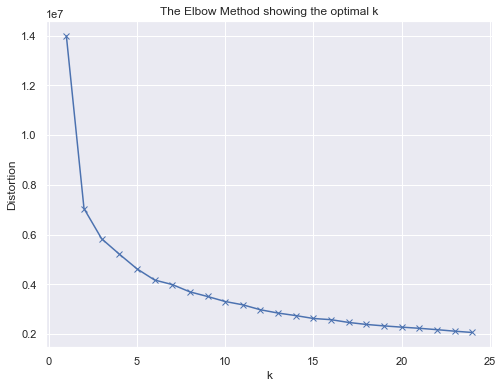

In [254]:
plt.figure(figsize=(8,6))
plt.plot(KNN, distortions_KNN, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [255]:
knn = KNeighborsClassifier(n_neighbors=5)

#Fit the model
knn.fit(X_train, y_train)

#Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)

#Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)

In [256]:
test_accuracy

0.7506253607850684

In [257]:
y_predKNN = knn.predict(X_test)

In [258]:
# Compute confusion matrix
cmKNN = confusion_matrix(y_test, y_predKNN)

In [259]:
print(classification_report(y_test,y_predKNN))

              precision    recall  f1-score   support

           2       0.71      0.84      0.77      7823
           3       0.81      0.66      0.72      7768

    accuracy                           0.75     15591
   macro avg       0.76      0.75      0.75     15591
weighted avg       0.76      0.75      0.75     15591



In [260]:
train_accuracy

0.8379834519915336